#### Adicionando o caminho do projeto ao path

In [1]:
import os
os.chdir('/Users/edithvidal/Documents/Github/data_science_analysis/')

#### Instalando sklearn

In [2]:
%pip install scikit-learn


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


#### Importando as bibliotecas necessárias para a análise

In [3]:
import pandas as pd  # type: ignore
import numpy as np  # type: ignore
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from scipy.stats import chi2_contingency

#### Lendo os dados da base tratada de 2018 a 2024

In [4]:
df_accidents = pd.read_csv(
    "wrangling/datatran2018_2024_v1.csv",
    parse_dates=["data_inversa", "mes_ano"]
)
df_accidents.info()
df_accidents.reset_index(drop=True, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429769 entries, 0 to 429768
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      429769 non-null  float64       
 1   data_inversa            429769 non-null  datetime64[ns]
 2   tipo_data               429769 non-null  object        
 3   mes_ano                 429769 non-null  datetime64[ns]
 4   dia_semana              429769 non-null  object        
 5   horario                 429769 non-null  object        
 6   fase_dia                429769 non-null  object        
 7   condicao_metereologica  429769 non-null  object        
 8   uf                      429769 non-null  object        
 9   br                      429769 non-null  float64       
 10  km                      429769 non-null  object        
 11  uso_solo                429769 non-null  object        
 12  tipo_pista              429769

#### Criando funções auxiliares para gerar os gráficos

In [5]:
def draw_histplot(
    df,
    title="Histograma",
    x_label="",
    y_label="Frequência",
    width=8,
    height=5,
    bins=20,
    orient="v",
    rotation=False,
    center_x_label=True,
    set_yscale=False
):
    if df.dtype == "float64" or df.dtype == "int64":
        mean = df.mean()
        median = df.median()
        mode = df.mode().iloc[0]
    else:
        mean = df.value_counts().mean()
        median = df.value_counts().median()
        mode = df.value_counts().mode().iloc[0]

    plt.figure(figsize=(width, height))
    if set_yscale:
        ax = sns.histplot(data=df, color="skyblue", bins=bins)
        ax.set_yscale("log")
    else:
        sns.histplot(data=df, color="skyblue", bins=bins)
    if orient == "v":
        plt.axvline(
            mean,
            color='red',
            linestyle='-',
            linewidth=2,
            label=f'Média: {mean:.0f}'
        )

        plt.axvline(
            median,
            color='green',
            linestyle='-',
            linewidth=2,
            label=f'Mediana: {median:.0f}'
        )

        plt.axvline(
            mode,
            color='blue', linestyle='-',
            linewidth=2,
            label=f'Moda: {mode:.0f}'
        )
    else:
        plt.axhline(
            mean,
            color='red',
            linestyle='-',
            linewidth=2,
            label=f'Média: {mean:.0f}'
        )

        plt.axhline(
            median,
            color='green',
            linestyle='-',
            linewidth=2,
            label=f'Mediana: {median:.0f}'
        )

        plt.axhline(
            mode,
            color='blue', linestyle='-',
            linewidth=2,
            label=f'Moda: {mode:.0f}'
        )
    plt.legend(fontsize="14", loc="best")
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(
        ha="center" if center_x_label else "right",
        rotation=45 if rotation else None)
    plt.tick_params(axis='x', labelsize=13)
    plt.tick_params(axis='y', labelsize=13)
    plt.margins(x=0)
    plt.show()


def draw_boxplot(
    df,
    title="Gráfico de caixas",
    x_label="",
    y_label="Frequência",
    width=8,
    height=5,
    multipleLocator=1,
):
    plt.figure(figsize=(width, height))
    sns.boxplot(df, y=df.columns[1])
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.gca().yaxis.set_major_locator(
        mticker.MultipleLocator(multipleLocator))
    plt.gca().yaxis.set_major_formatter(
        mticker.StrMethodFormatter("{x:.0f}"))
    plt.show()


def draw_barplot(enable_lineplot, set_yscale, df, x, y, title):
    plt.figure(figsize=(25, 6))
    if set_yscale:
        ax = sns.barplot(
            data=df,
            x=x,
            y=y,
            color="skyblue"
        )
        ax.set_yscale("log")
    else:
        sns.barplot(
            data=df,
            x=x,
            y=y,
            color="skyblue"
        )

    if enable_lineplot:
        sns.lineplot(
            data=df,
            x=x,
            y=y,
            marker="o",
            color="red",
            linewidth=1
        )
        plt.grid(axis="y", linestyle="--", alpha=0.5)

    plt.title(title, fontsize=16)
    plt.ylabel("Frequência de acidentes")
    plt.xticks(rotation=45, ha="right")
    plt.margins(x=0)
    plt.tick_params(axis='x', labelsize=13)
    plt.tick_params(axis='y', labelsize=13)
    plt.show()


def draw_pie(df, labels, title="", figsize=(8, 8)):
    colors = sns.color_palette("pastel")[:len(labels)]

    plt.figure(figsize=figsize)
    plt.pie(
        x=df,
        labels=labels,
        autopct="%1.1f%%",
        colors=colors
    )
    plt.title(title)
    plt.show()

#### Criando funções auxiliares para as análises

In [6]:
def get_weekdays():
    return [
        "Domingo",
        "Segunda-feira",
        "Terça-feira",
        "Quarta-feira",
        "Quinta-feira",
        "Sexta-feira",
        "Sábado"
    ]

def to_datetime(df):
    return pd.to_datetime(df, format="%H:%M:%S").dt.hour


def melt(table, id_vars, var_name, value_name):
    data = table.melt(
        id_vars=id_vars, var_name=var_name, value_name=value_name)
    return data.to_dict(orient="records")

## Análise univariada

#### Análise da distribuição dos acidentes por mês e ano (2018)

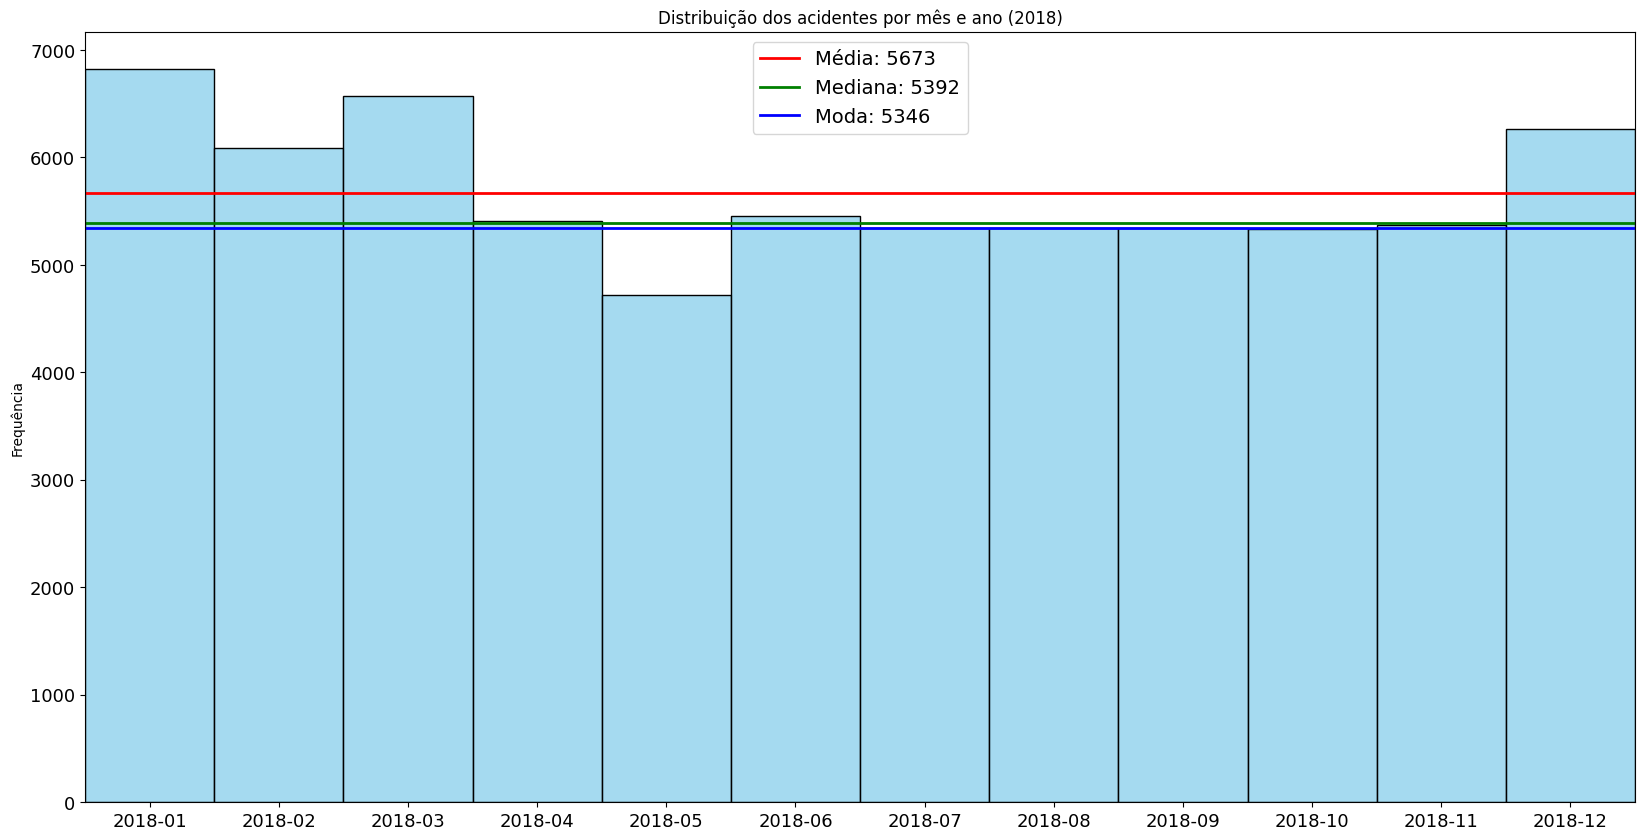

In [7]:
df = df_accidents.copy()
df = df_accidents[df_accidents["mes_ano"].dt.year == 2018]
draw_histplot(
    df=df["mes_ano"].dt.strftime('%Y-%m'),
    title="Distribuição dos acidentes por mês e ano (2018)",
    orient="h",
    width=20,
    height=10,
    bins=12
)

#### Análise da distribuição dos acidentes por mês e ano (2019)

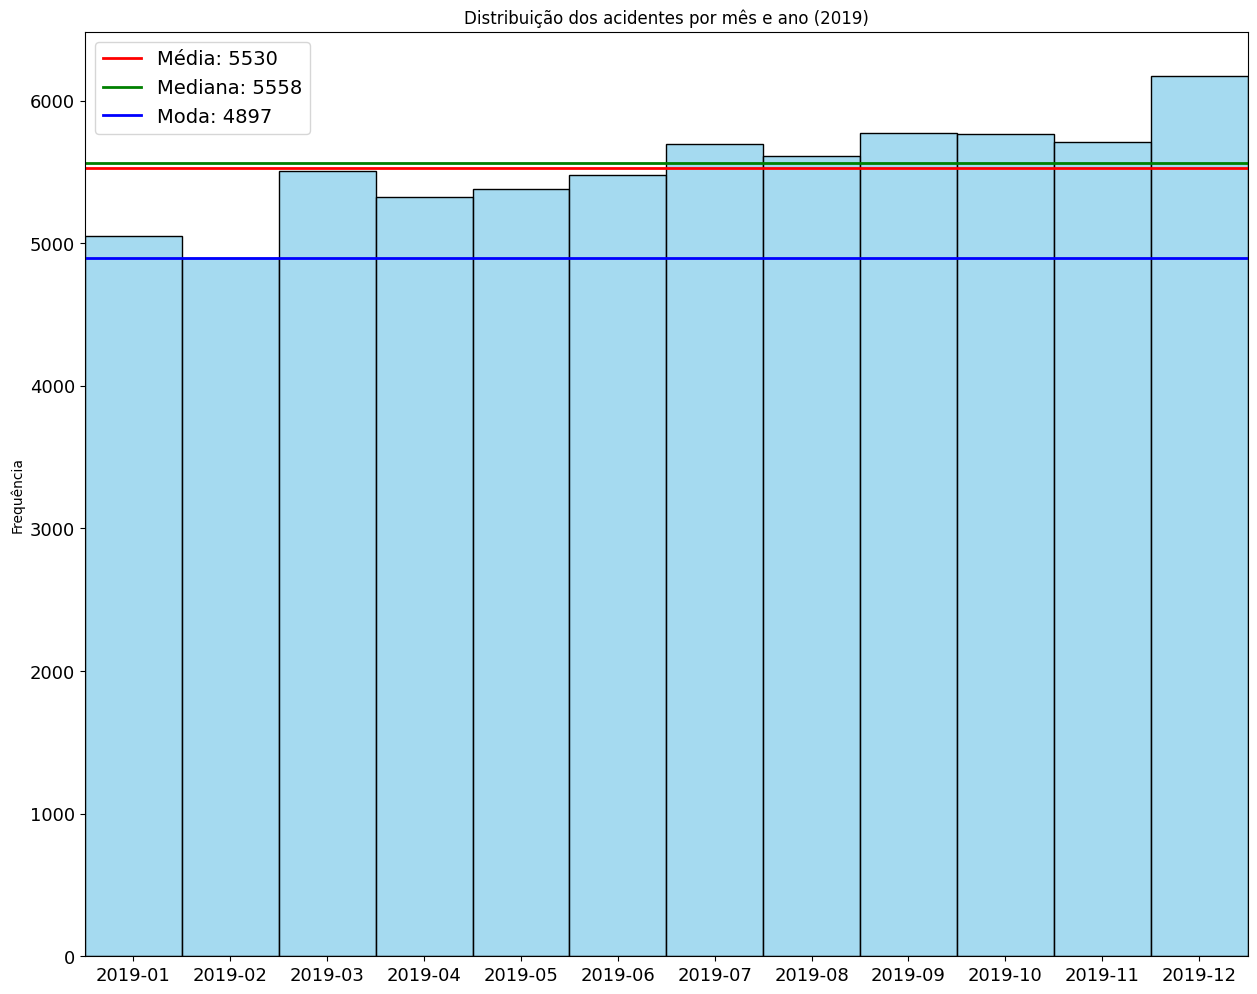

In [8]:
df = df_accidents.copy()
df = df_accidents[df_accidents["mes_ano"].dt.year == 2019]
draw_histplot(
    df=df["mes_ano"].dt.strftime('%Y-%m'),
    title="Distribuição dos acidentes por mês e ano (2019)",
    orient="h",
    width=15,
    height=12,
    bins=12
)

#### Análise da distribuição dos acidentes por mês e ano (2020)

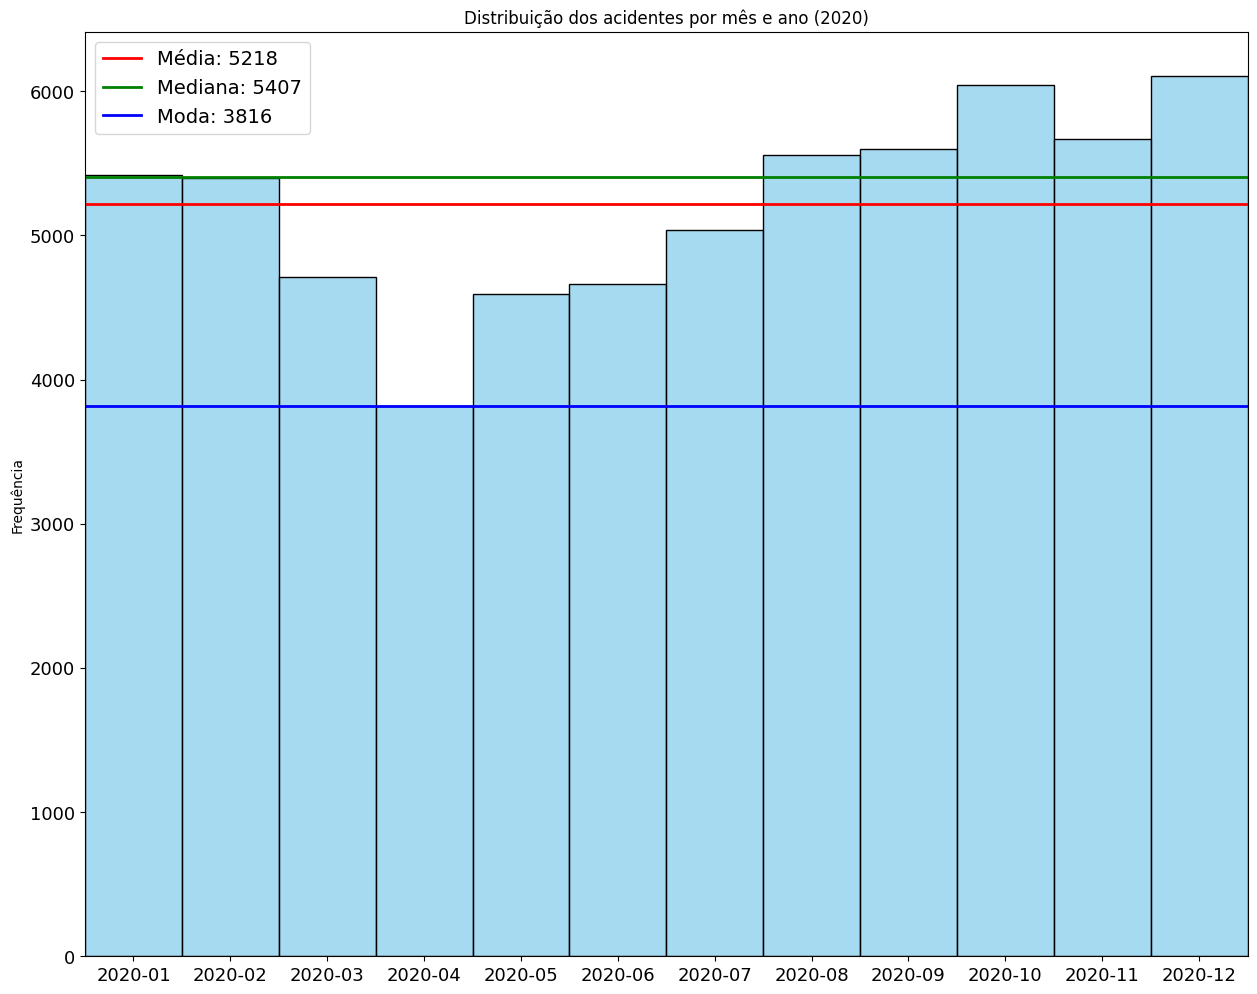

In [9]:
df = df_accidents.copy()
df = df_accidents[df_accidents["mes_ano"].dt.year == 2020]
draw_histplot(
    df=df["mes_ano"].dt.strftime('%Y-%m'),
    title="Distribuição dos acidentes por mês e ano (2020)",
    orient="h",
    width=15,
    height=12,
    bins=12
)

#### Análise da distribuição dos acidentes por mês e ano (2021)

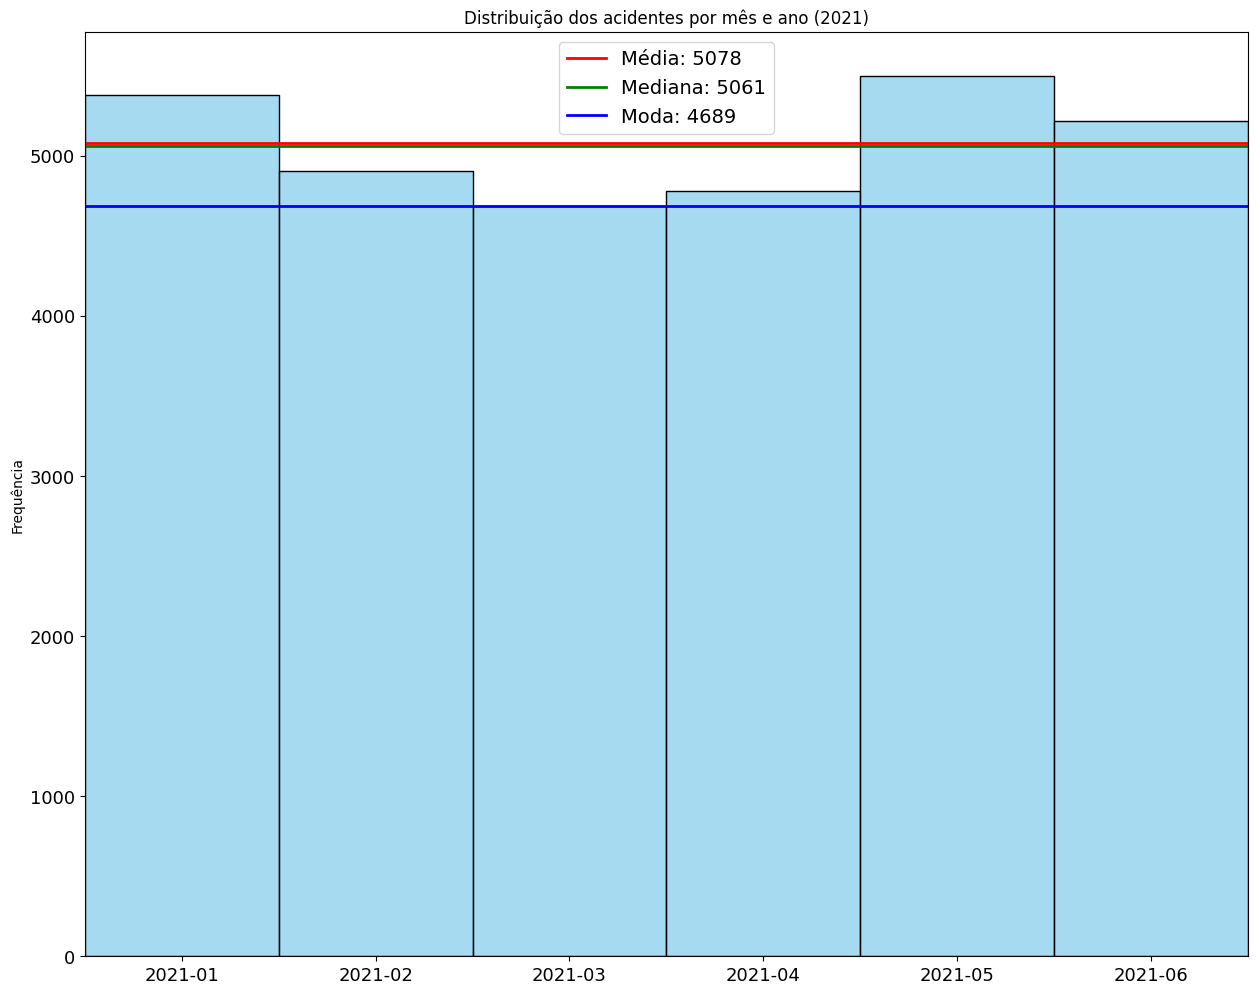

In [10]:
df = df_accidents.copy()
df = df_accidents[df_accidents["mes_ano"].dt.year == 2021]
draw_histplot(
    df=df["mes_ano"].dt.strftime('%Y-%m'),
    title="Distribuição dos acidentes por mês e ano (2021)",
    orient="h",
    width=15,
    height=12,
    bins=12
)

#### Análise da distribuição dos acidentes por mês e ano (2022)

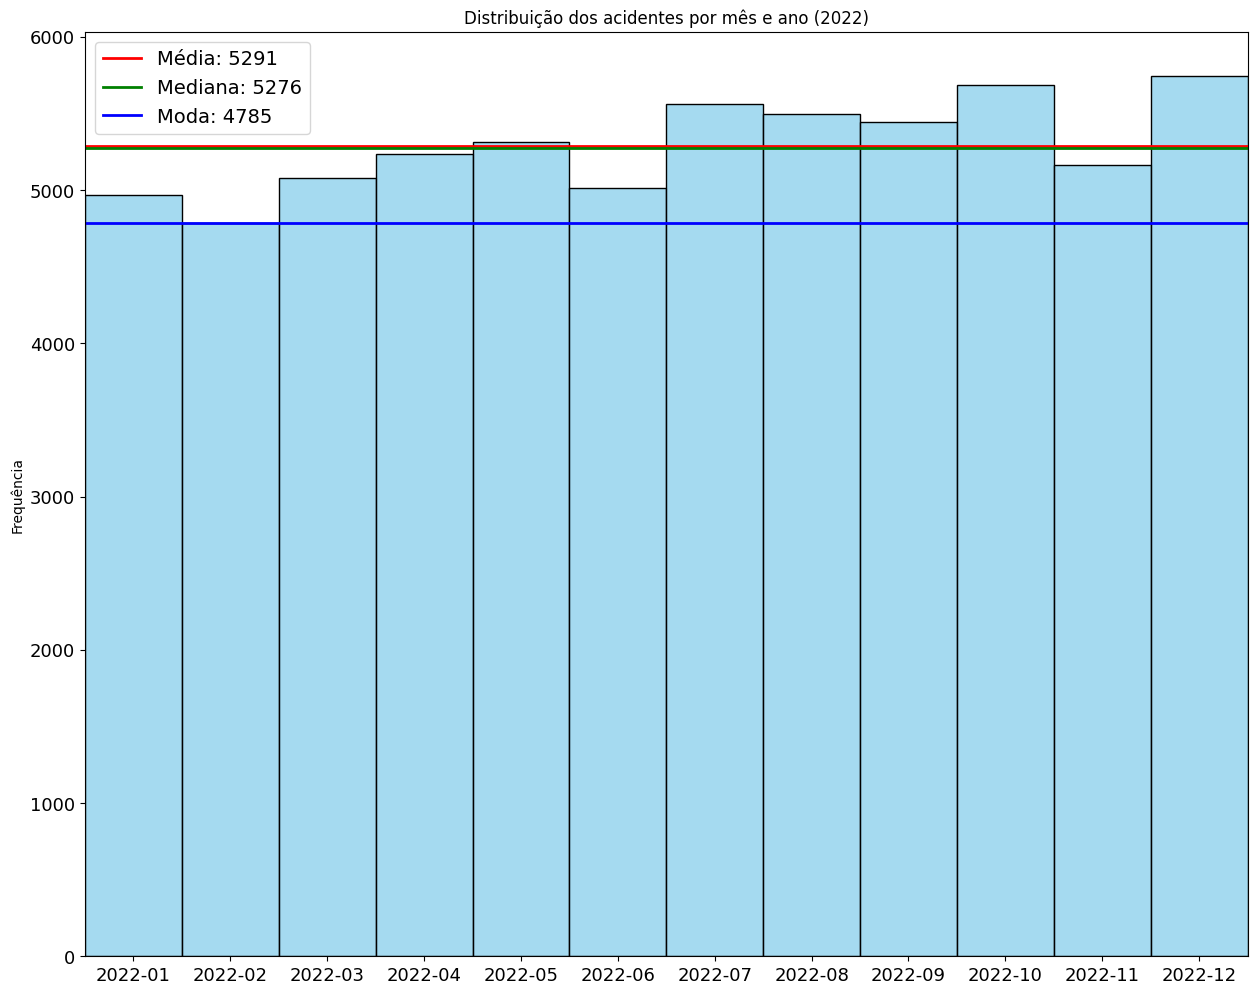

In [11]:
df = df_accidents.copy()
df = df_accidents[df_accidents["mes_ano"].dt.year == 2022]
draw_histplot(
    df=df["mes_ano"].dt.strftime('%Y-%m'),
    title="Distribuição dos acidentes por mês e ano (2022)",
    orient="h",
    width=15,
    height=12,
    bins=12
)

#### Análise da distribuição dos acidentes por mês e ano (2023)

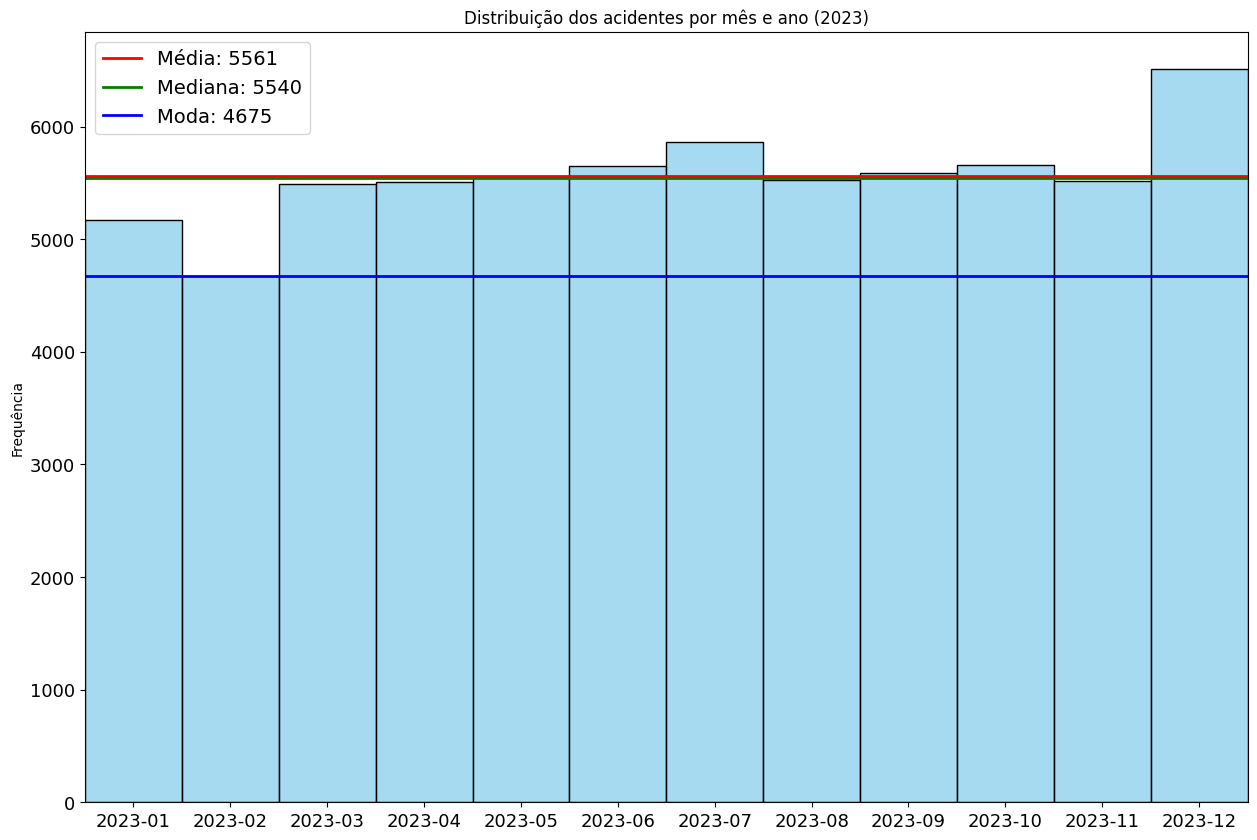

In [12]:
df = df_accidents.copy()
df = df_accidents[df_accidents["mes_ano"].dt.year == 2023]
draw_histplot(
    df=df["mes_ano"].dt.strftime('%Y-%m'),
    title="Distribuição dos acidentes por mês e ano (2023)",
    orient="h",
    width=15,
    height=10,
    bins=12
)

#### Análise da distribuição dos acidentes por mês e ano (2024)

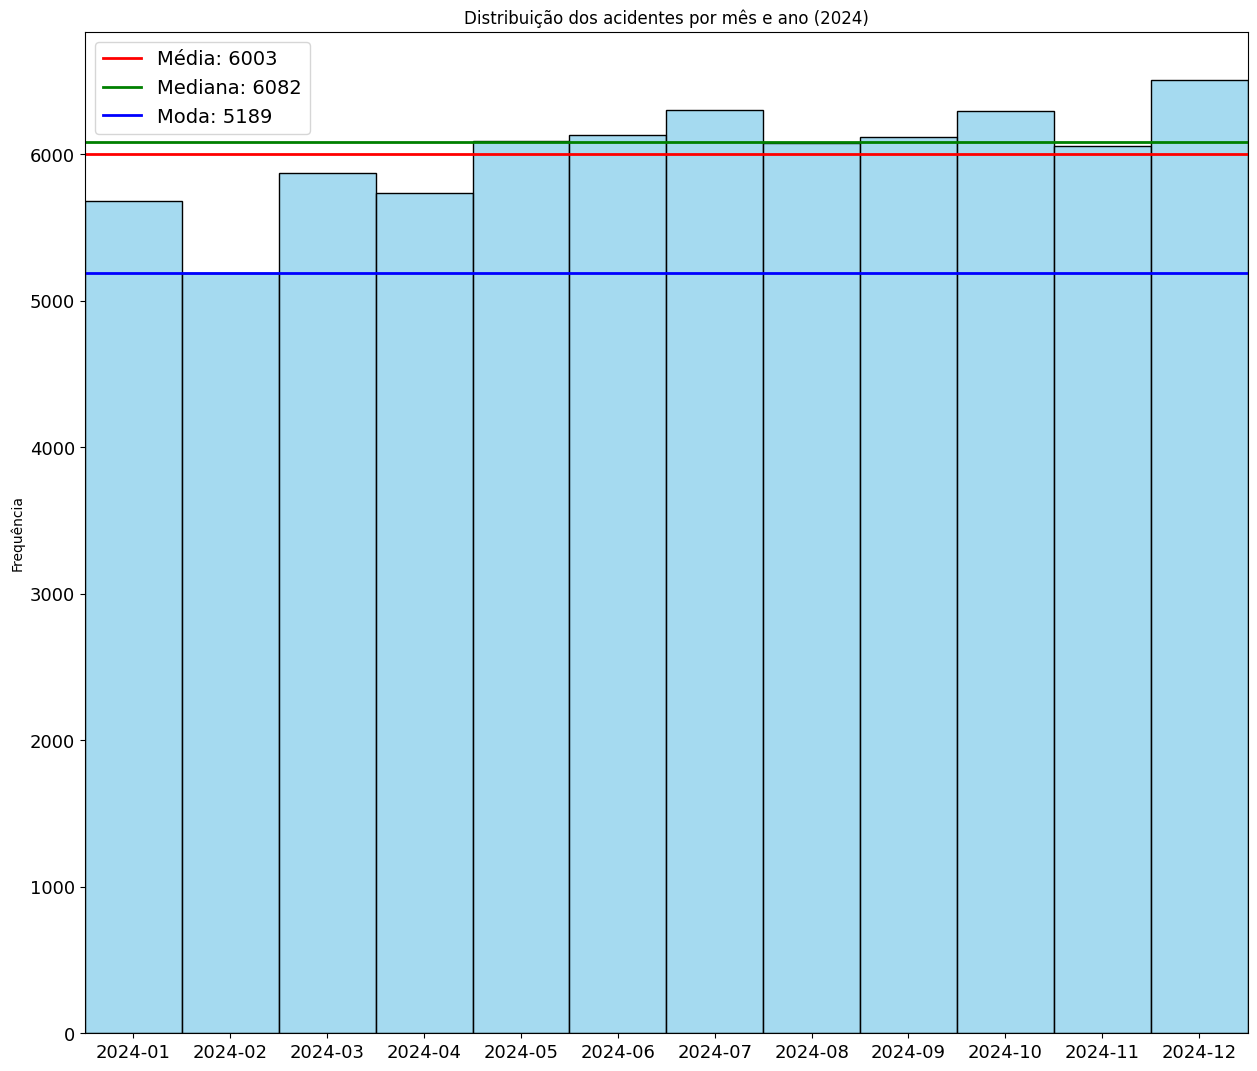

In [13]:
df = df_accidents.copy()
df = df_accidents[df_accidents["mes_ano"].dt.year == 2024]
draw_histplot(
    df=df["mes_ano"].dt.strftime('%Y-%m'),
    title="Distribuição dos acidentes por mês e ano (2024)",
    orient="h",
    width=15,
    height=13,
    bins=12
)

#### Análise da distribuição dos acidentes por ano

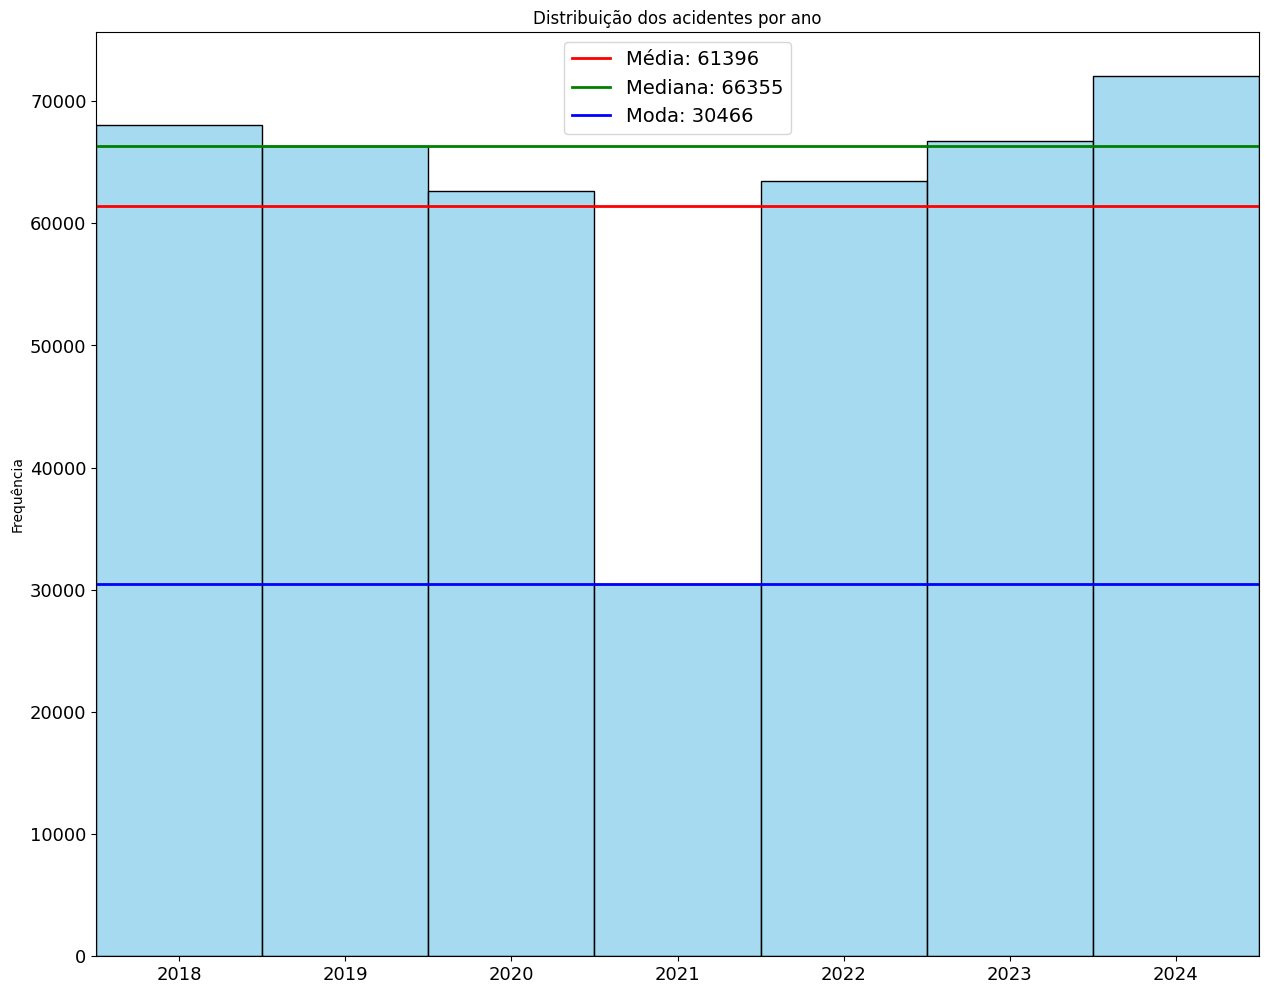

In [14]:
df = df_accidents.copy()
draw_histplot(
    df=df["mes_ano"].dt.strftime('%Y'),
    title="Distribuição dos acidentes por ano",
    orient="h",
    width=15,
    height=12,
    bins=12
)

#### Analisando os dados do ano de 2021, foi possível perceber que os meses de julho a dezembro não foram populados. Para não influenciar negativamente nas análises, preencherei esses dados considerando a média ou mediana dos demais anos

In [15]:
end_of_month = dict({7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31})


def fill_occurrences_dict(df, day, month, year):
    occurrences_dict = {}
    current_date = f'{year}-{month:02d}-{day:02d}'
    count = df_accidents[df == current_date].shape[0]
    occurrences_dict[current_date] = count
    return occurrences_dict


def create_lines_by_mean(day, month, mean):
    value = [pd.to_datetime(f'2021-{month:02d}-{day:02d}')] * mean
    return pd.DataFrame({
        'data_inversa': value, 'mes_ano': value,
    })


def fill_na(df):
    for col in df_accidents.columns:
        if col not in ('data_inversa', 'mes_ano'):
            df[col] = np.nan
    return df


for month in end_of_month:
    for day in range(1, end_of_month[month] + 1):
        for year in [2018, 2019, 2020, 2022, 2023, 2024]:
            occurrences = fill_occurrences_dict(
                df_accidents["data_inversa"], day, month, year)

        mean = int(np.mean(list(occurrences.values())))

        df = create_lines_by_mean(day, month, mean)
        df = fill_na(df)

        df_accidents = pd.concat(
            [df_accidents, df], ignore_index=True)

df_accidents["mes_ano"] = df_accidents["data_inversa"].dt.to_period("M")
df_accidents.drop(columns=["data_inversa"], inplace=True)
df_accidents.to_csv(
    "analysis/datatran2018_2024_v2.csv", index=False)

#### Lendo a nova base de dados após o tratamento do ano de 2021

In [16]:
df_accidents = pd.read_csv(
    "analysis/datatran2018_2024_v2.csv",
    parse_dates=["mes_ano"]
)
df_accidents.reset_index(drop=True, inplace=True)

/var/folders/z1/3syxl8gd5ks431s8c9n9mrs00000gn/T/ipykernel_17302/2782063256.py:1: DtypeWarning: Columns (1,3,4,5,6,7,9,10,11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_accidents = pd.read_csv(


#### Análise da distribuição dos acidentes por mês e ano (após tratamento de 2021)

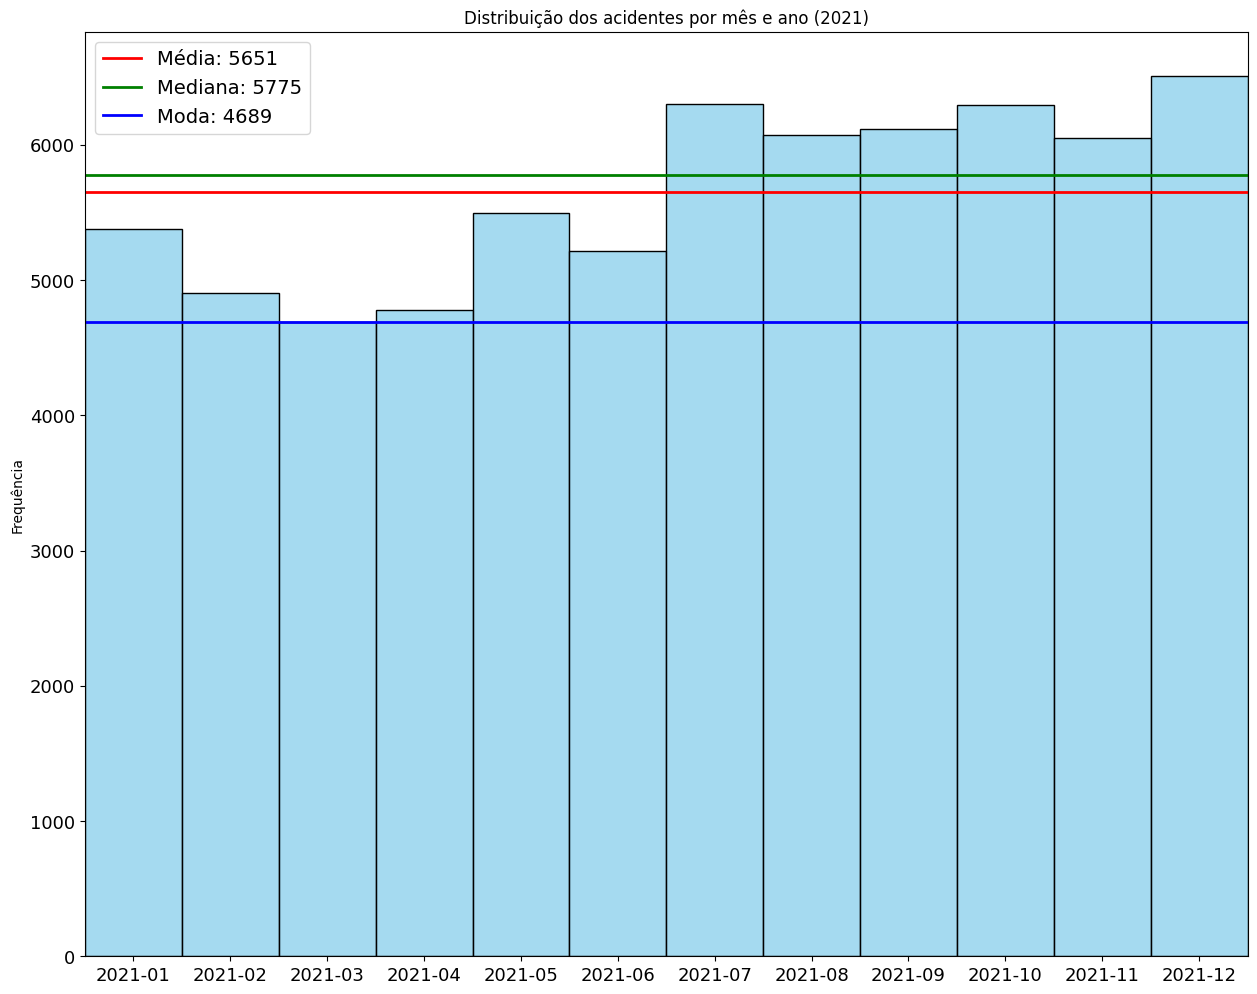

In [17]:
df = df_accidents.copy()
df = df_accidents[df_accidents["mes_ano"].dt.year == 2021]
draw_histplot(
    df=df["mes_ano"].dt.strftime('%Y-%m'),
    title="Distribuição dos acidentes por mês e ano (2021)",
    orient="h",
    width=15,
    height=12,
    bins=12
)

#### Análise da distribuição dos acidentes por ano (após tratamento de 2021)

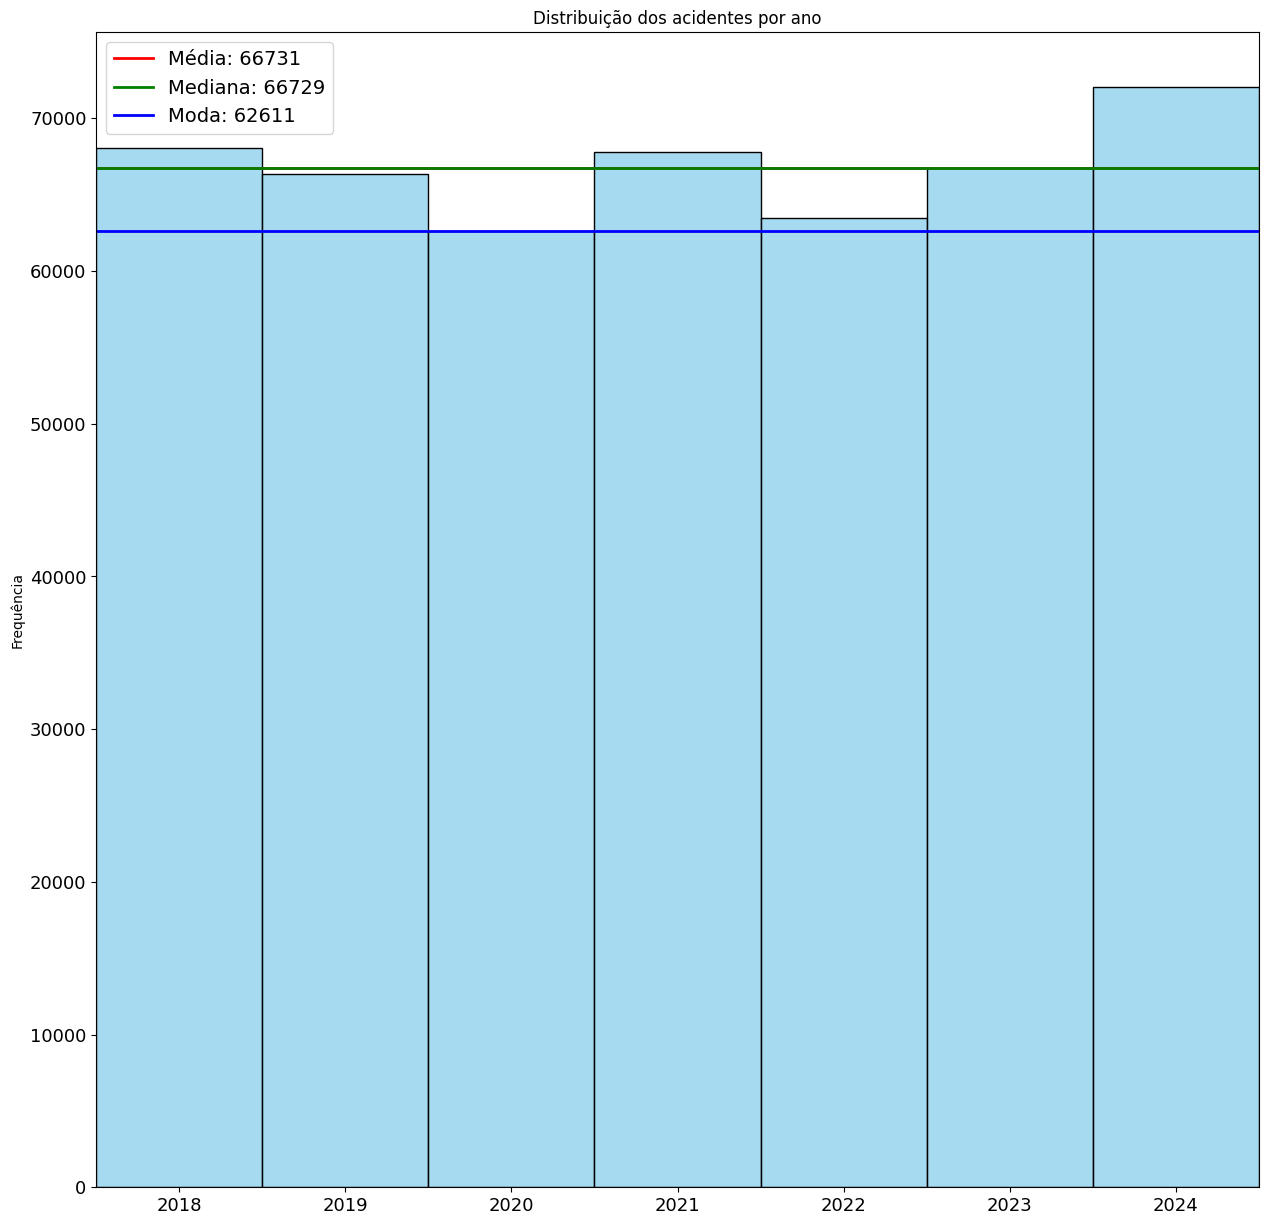

In [18]:
df = df_accidents.copy()
draw_histplot(
    df=df["mes_ano"].dt.strftime('%Y'),
    title="Distribuição dos acidentes por ano",
    orient="h",
    width=15,
    height=15,
    bins=12
)

#### Análise univariada da coluna tipo_data, agrupando por Feriado ou Dia útil

                   tipo_data  frequencia
0   Dia da consciência negra         152
1                    Finados        1054
2          Sexta-feira Santa        1120
3                      Natal        1135
4                   Carnaval        1180
5             Corpus Christi        1203
6                     Páscoa        1211
7    Independência do Brasil        1224
8    Nossa Senhora Aparecida        1237
9   Proclamação da República        1249
10           Dia do trabalho        1254
11                Tiradentes        1262
12  Confraternização mundial        1411
13                  Dia útil      415077


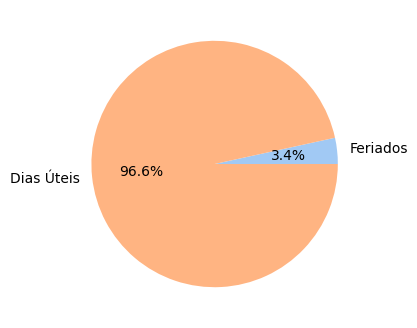

In [19]:
df_copy = df_accidents.copy()
df_copy.dropna(inplace=True)
df_copy = df_copy["tipo_data"].value_counts().sort_values().reset_index()
df_copy.columns = ["tipo_data", "frequencia"]
print(df_copy)

df = pd.DataFrame(
    {
        "categoria":
            ["Feriados", "Dias Úteis"],
        "frequencia": [
            df_copy[df_copy["tipo_data"] != "Dia útil"]["frequencia"].sum(),
            df_copy[df_copy["tipo_data"] == "Dia útil"]["frequencia"].sum()
                ]
    }
)

draw_pie(
    df=df["frequencia"],
    labels=df["categoria"],
    figsize=(4, 4)
)

#### Analisando os feriados com mais ocorrências de acidentes

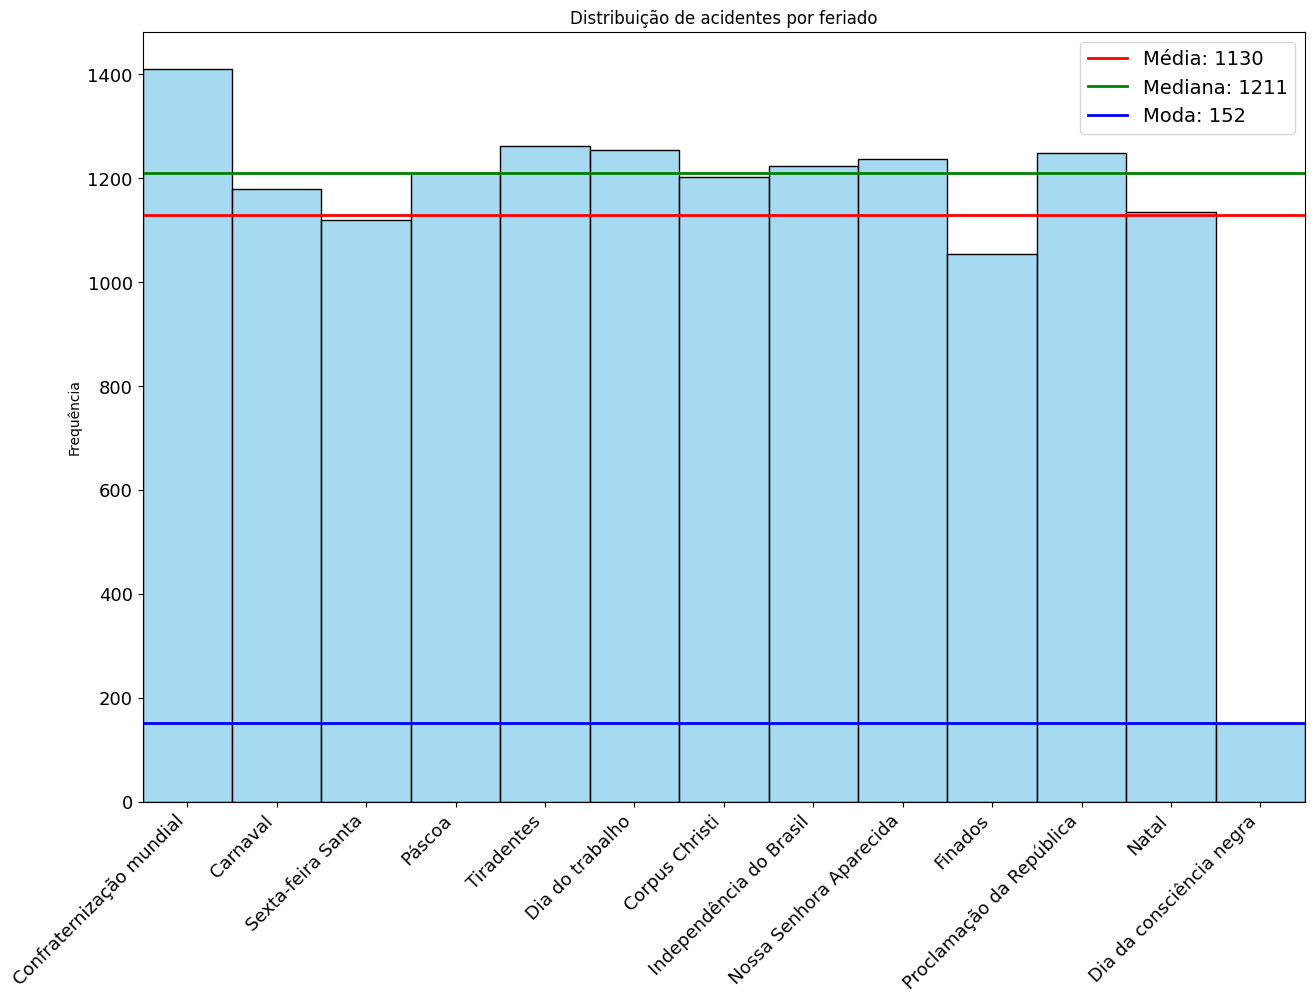

In [20]:
df = df_accidents.copy()
df = df.dropna(subset="tipo_data")
df = df_accidents[df_accidents["tipo_data"] != "Dia útil"]
draw_histplot(
    df=df["tipo_data"],
    title="Distribuição de acidentes por feriado",
    orient="h",
    width=15,
    height=10,
    bins=20,
    rotation=True,
    center_x_label=False
)

#### Análise da distribuição de acidentes de acordo com o dia da semana

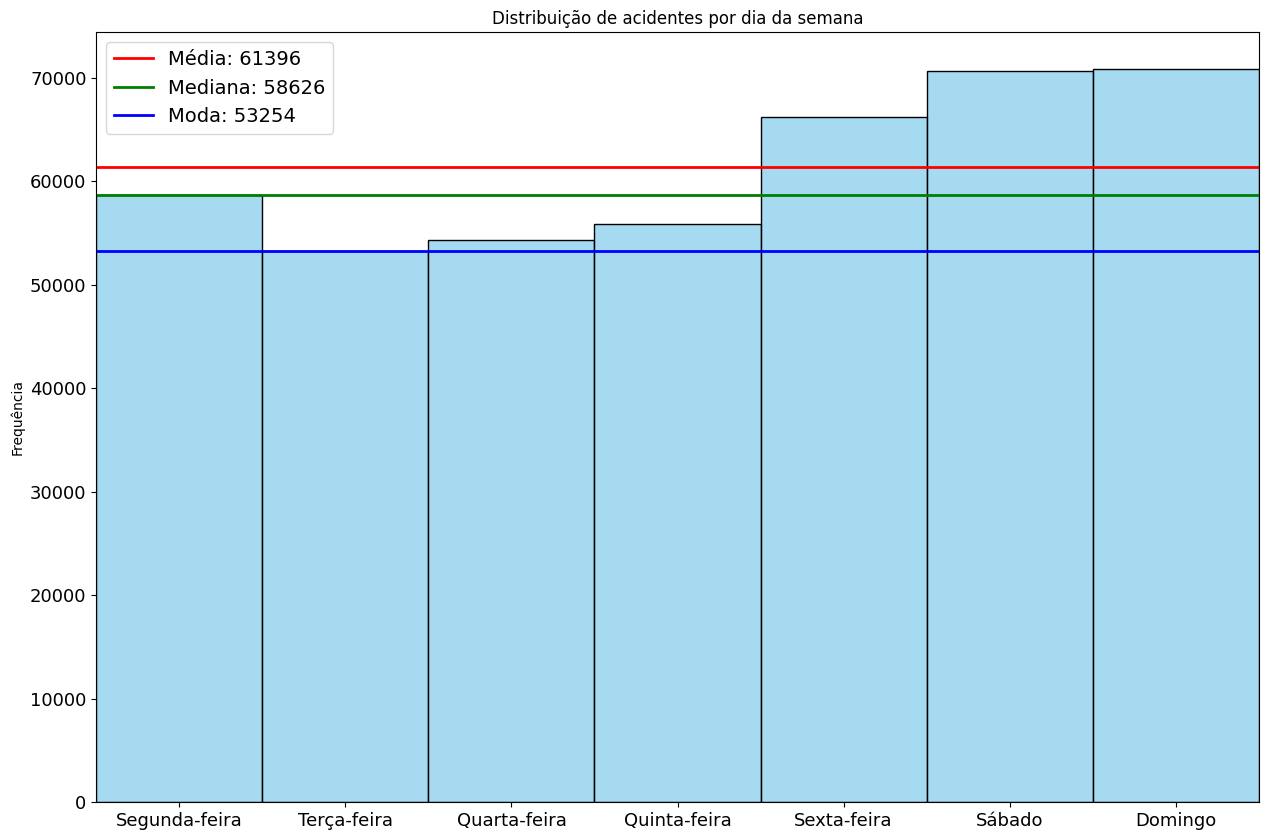

In [21]:
df = df_accidents.copy()
df = df.dropna(subset="dia_semana")
draw_histplot(
    df=df_accidents["dia_semana"],
    title="Distribuição de acidentes por dia da semana",
    orient="h",
    width=15,
    height=10
)

#### Análise da distribuição de acidentes por horário

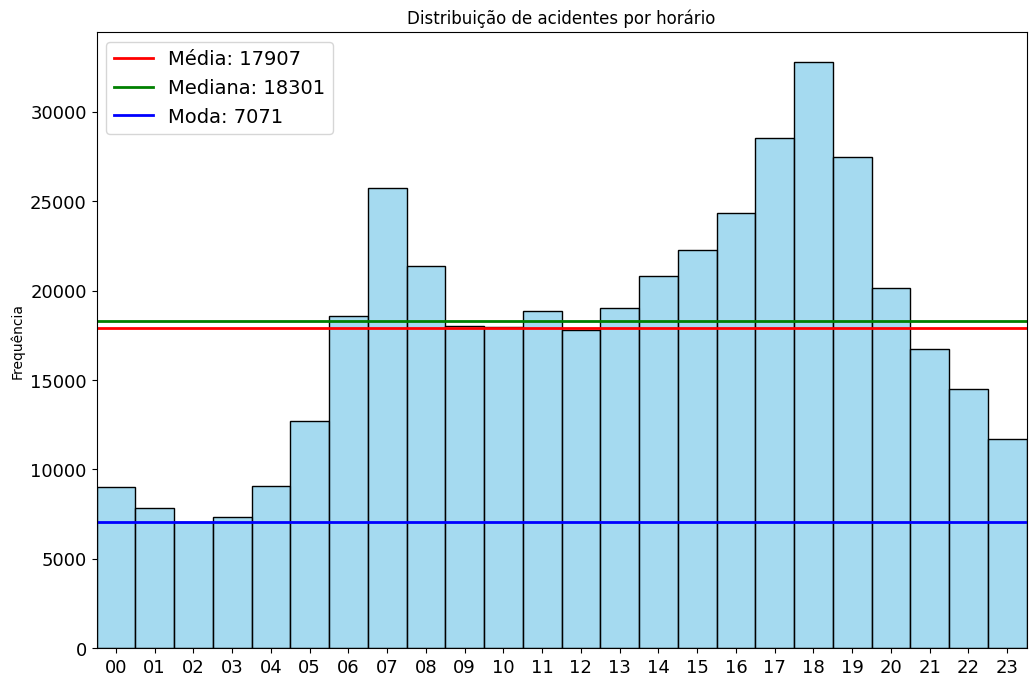

In [22]:
df = df_accidents.copy()
df = df.dropna(subset="horario")
df = df[df["horario"].notna()]["horario"]
df = pd.to_datetime(df, format="%H:%M:%S").dt.hour.astype(str).str.zfill(2)
draw_histplot(
    df=df.sort_values(),
    title="Distribuição de acidentes por horário",
    orient="h",
    width=12,
    height=8
)

#### Análise da distribuição de acidentes por fase do dia

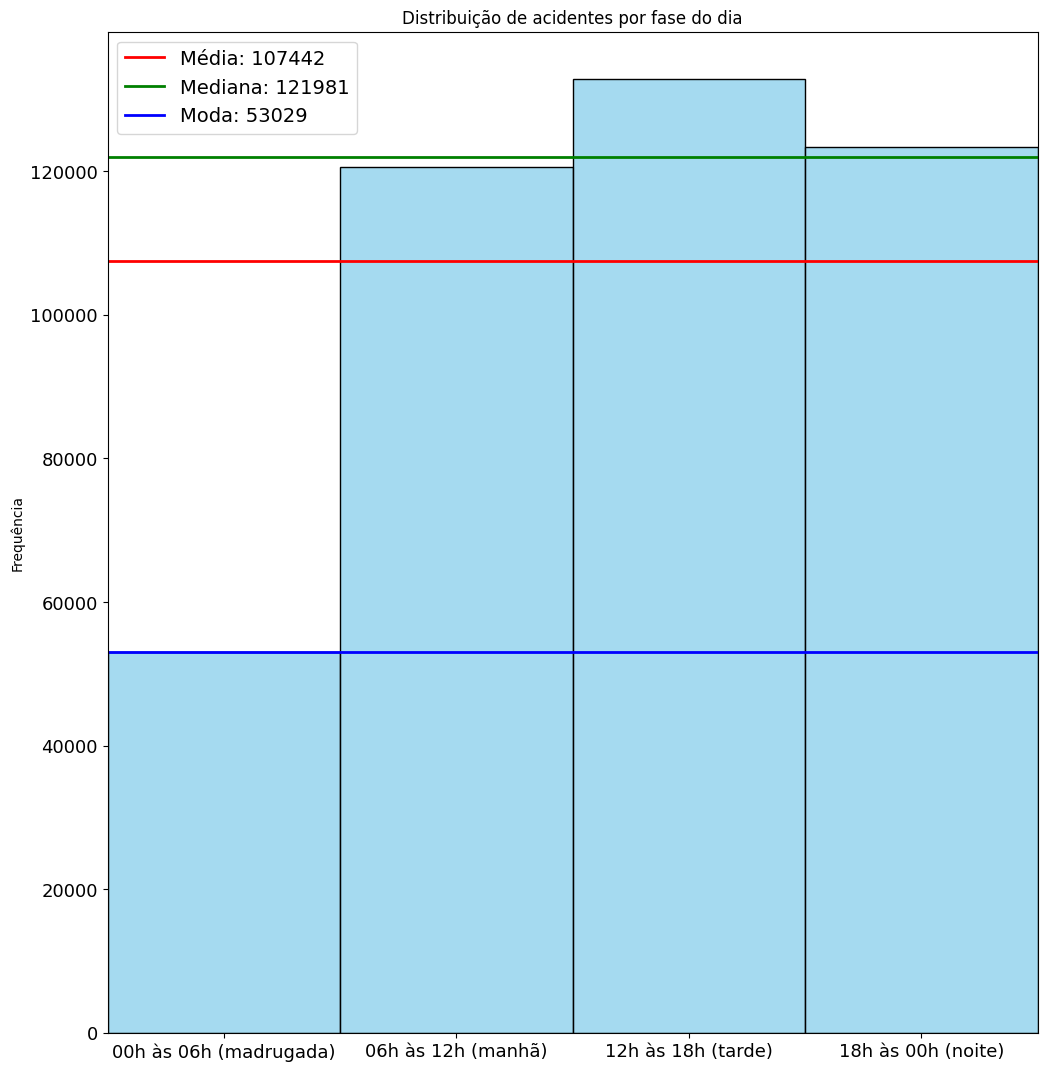

In [23]:
df = df_accidents.copy()
df = df.dropna(subset="fase_dia")
draw_histplot(
    df=df["fase_dia"].sort_values(),
    title="Distribuição de acidentes por fase do dia",
    orient="h",
    width=12,
    height=13,
)

#### Análise da distribuição de acidentes por condição meteorológica

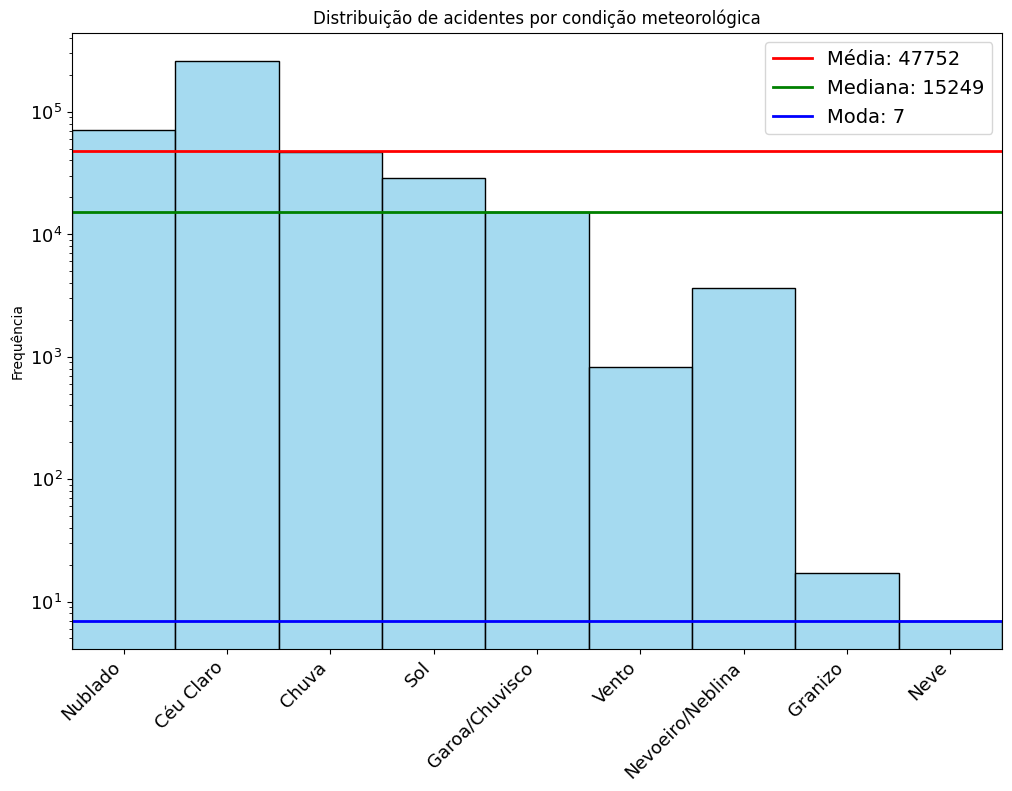

In [24]:
df = df_accidents.copy()
df = df.dropna(subset="condicao_metereologica")
draw_histplot(
    df=df["condicao_metereologica"].sort_index(),
    title="Distribuição de acidentes por condição meteorológica",
    orient="h",
    width=12,
    height=8,
    rotation=True,
    center_x_label=False,
    set_yscale=True
)

#### Análise da distribuição de maior número de acidentes por estado

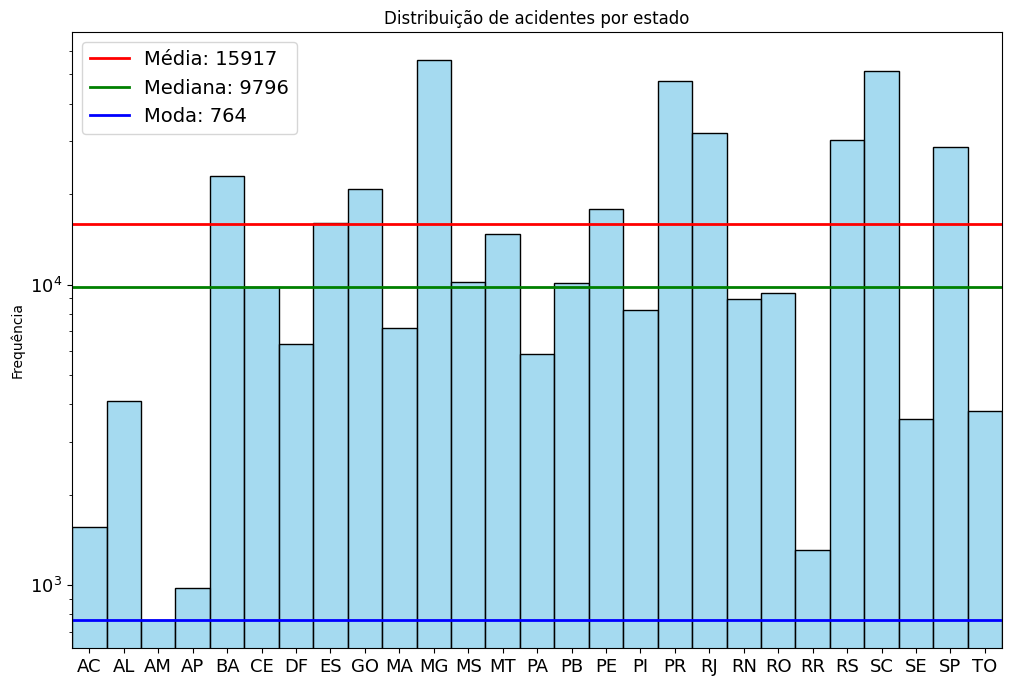

In [25]:
df = df_accidents.copy()
df = df.dropna(subset="uf")
draw_histplot(
    df=df["uf"].sort_values(ascending=True),
    title="Distribuição de acidentes por estado",
    orient="h",
    width=12,
    height=8,
    set_yscale=True
)

#### Análise da distribuição de maior número de acidentes por rodovia (radiais)

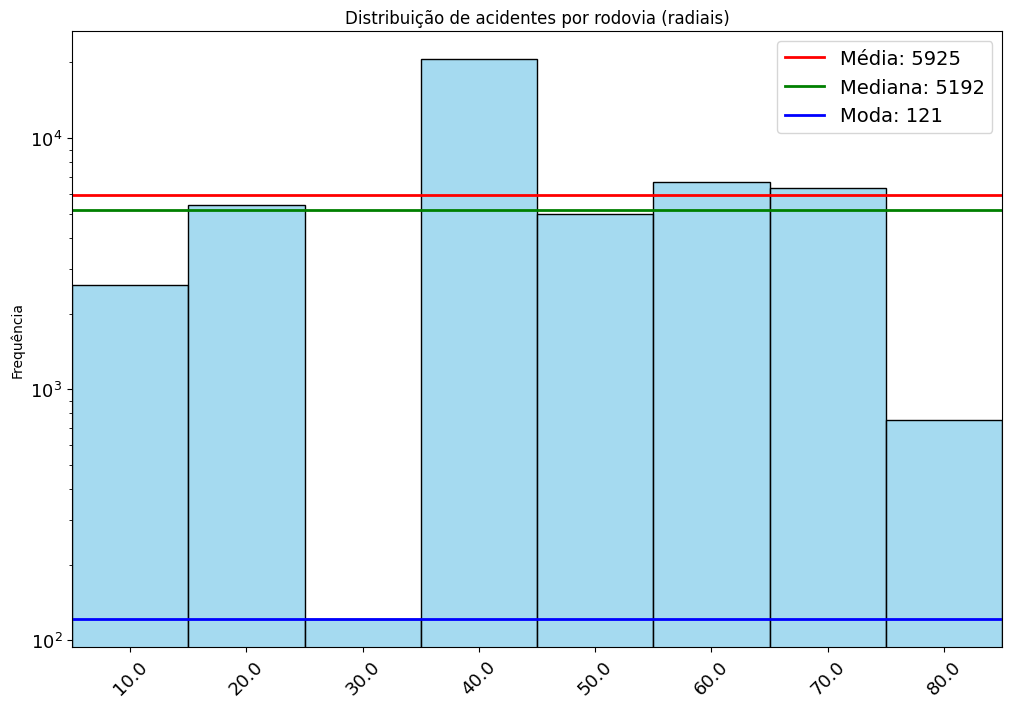

In [26]:
min_value, max_value = 10, 99
df = df_accidents.copy()
df = df.dropna(subset="br")
df = df[(df["br"] >= min_value) & (df["br"] <= max_value)]

draw_histplot(
    df=df["br"].sort_values().astype(str),
    title="Distribuição de acidentes por rodovia (radiais)",
    orient="h",
    width=12,
    height=8,
    rotation=True,
    set_yscale=True
)

#### Análise da distribuição de maior número de acidentes por rodovia (longitudinais)

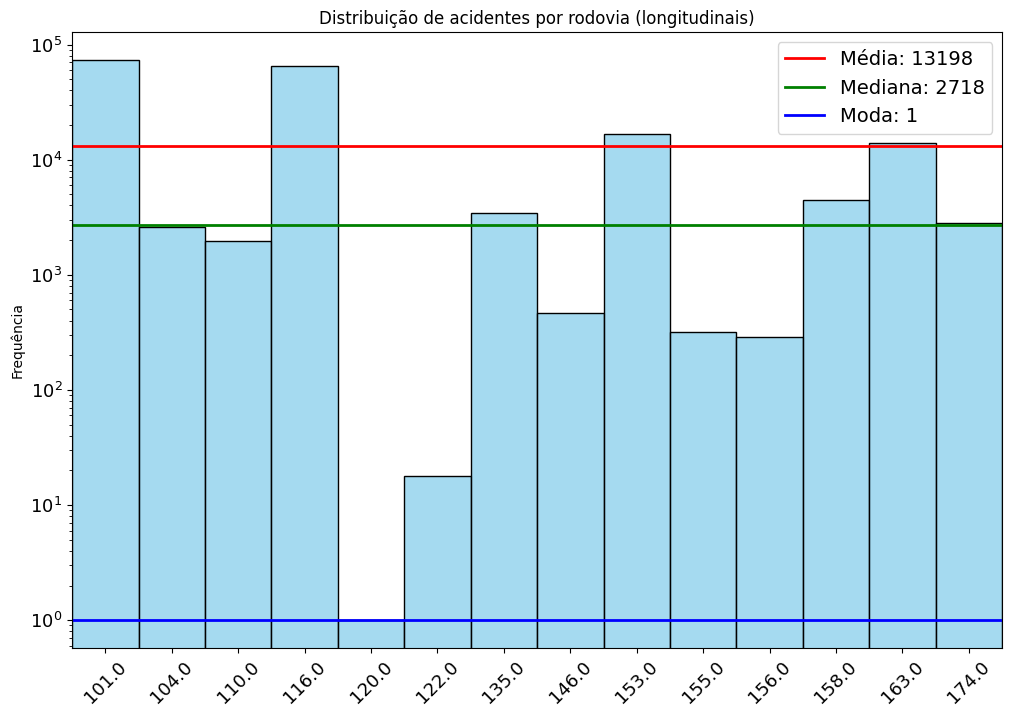

In [27]:
min_value, max_value = 100, 199
df = df_accidents.copy()
df = df.dropna(subset="br")
df = df[(df["br"] >= min_value) & (df["br"] <= max_value)]

draw_histplot(
    df=df["br"].sort_values().astype(str),
    title="Distribuição de acidentes por rodovia (longitudinais)",
    orient="h",
    width=12,
    height=8,
    rotation=True,
    set_yscale=True
)

#### Análise da distribuição de maior número de acidentes por rodovia (transversais)

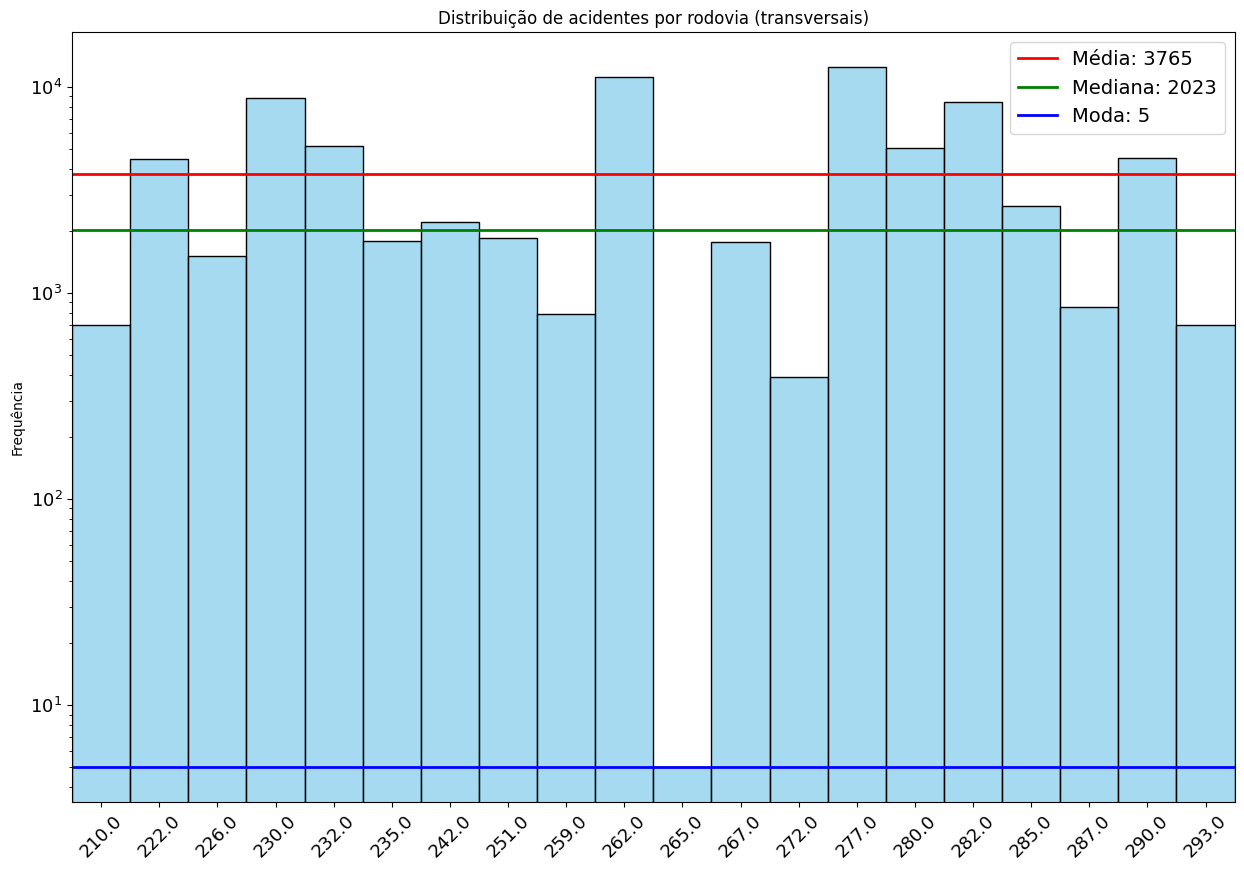

In [28]:
min_value, max_value = 200, 299
df = df_accidents.copy()
df = df.dropna(subset="br")
df = df[(df["br"] >= min_value) & (df["br"] <= max_value)]

draw_histplot(
    df=df["br"].sort_values().astype(str),
    title="Distribuição de acidentes por rodovia (transversais)",
    orient="h",
    width=15,
    height=10,
    rotation=True,
    set_yscale=True
)

#### Análise da distribuição de maior número de acidentes por rodovia (diagonais)

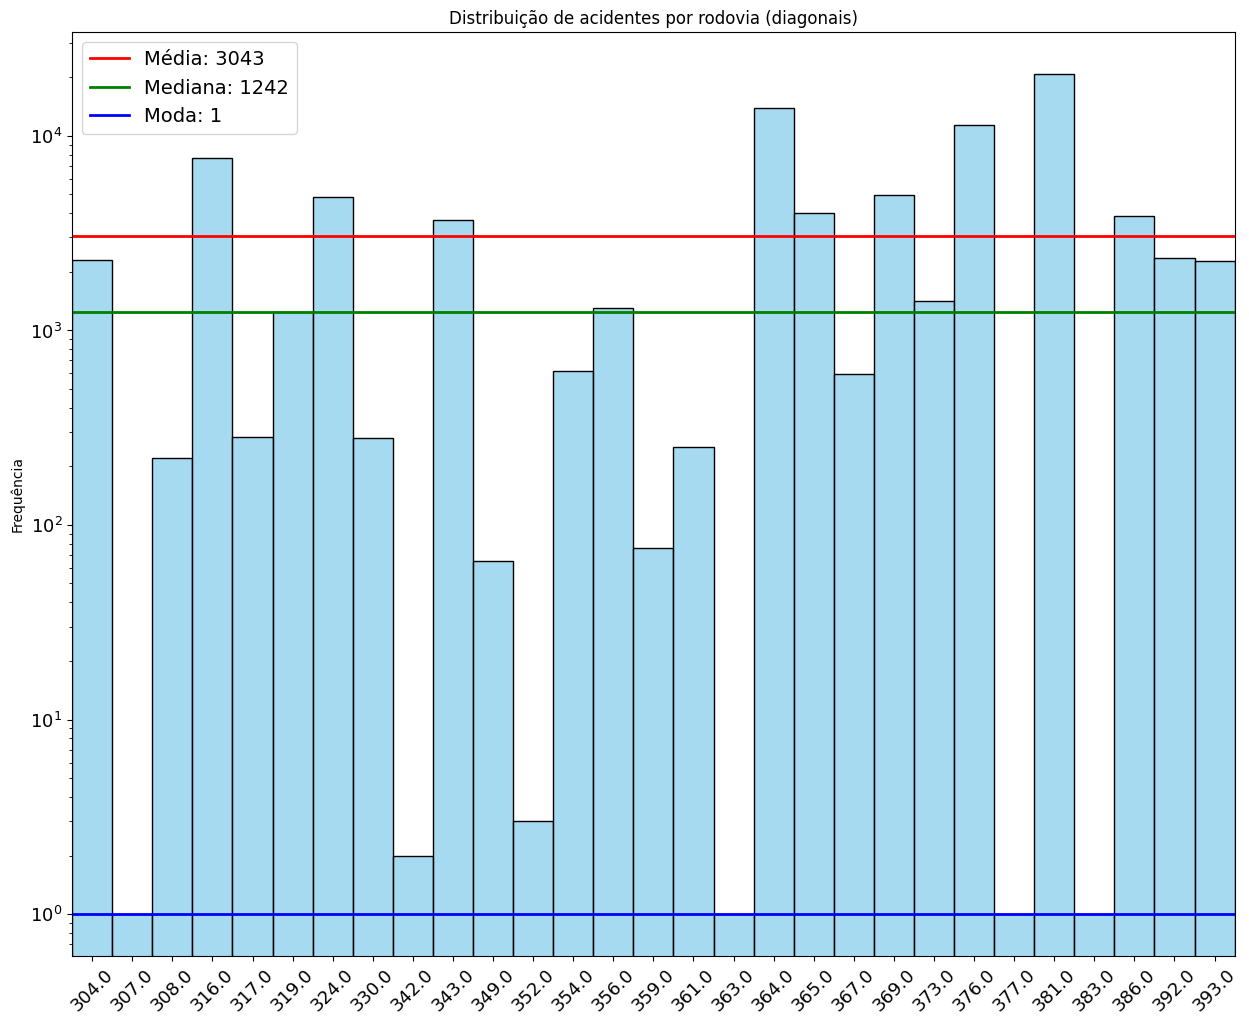

In [29]:
min_value, max_value = 300, 399
df = df_accidents.copy()
df = df.dropna(subset="br")
df = df[(df["br"] >= min_value) & (df["br"] <= max_value)]

draw_histplot(
    df=df["br"].sort_values().astype(str),
    title="Distribuição de acidentes por rodovia (diagonais)",
    orient="h",
    width=15,
    height=12,
    rotation=True,
    set_yscale=True
)

#### Análise da distribuição de maior número de acidentes por rodovia (de ligação)

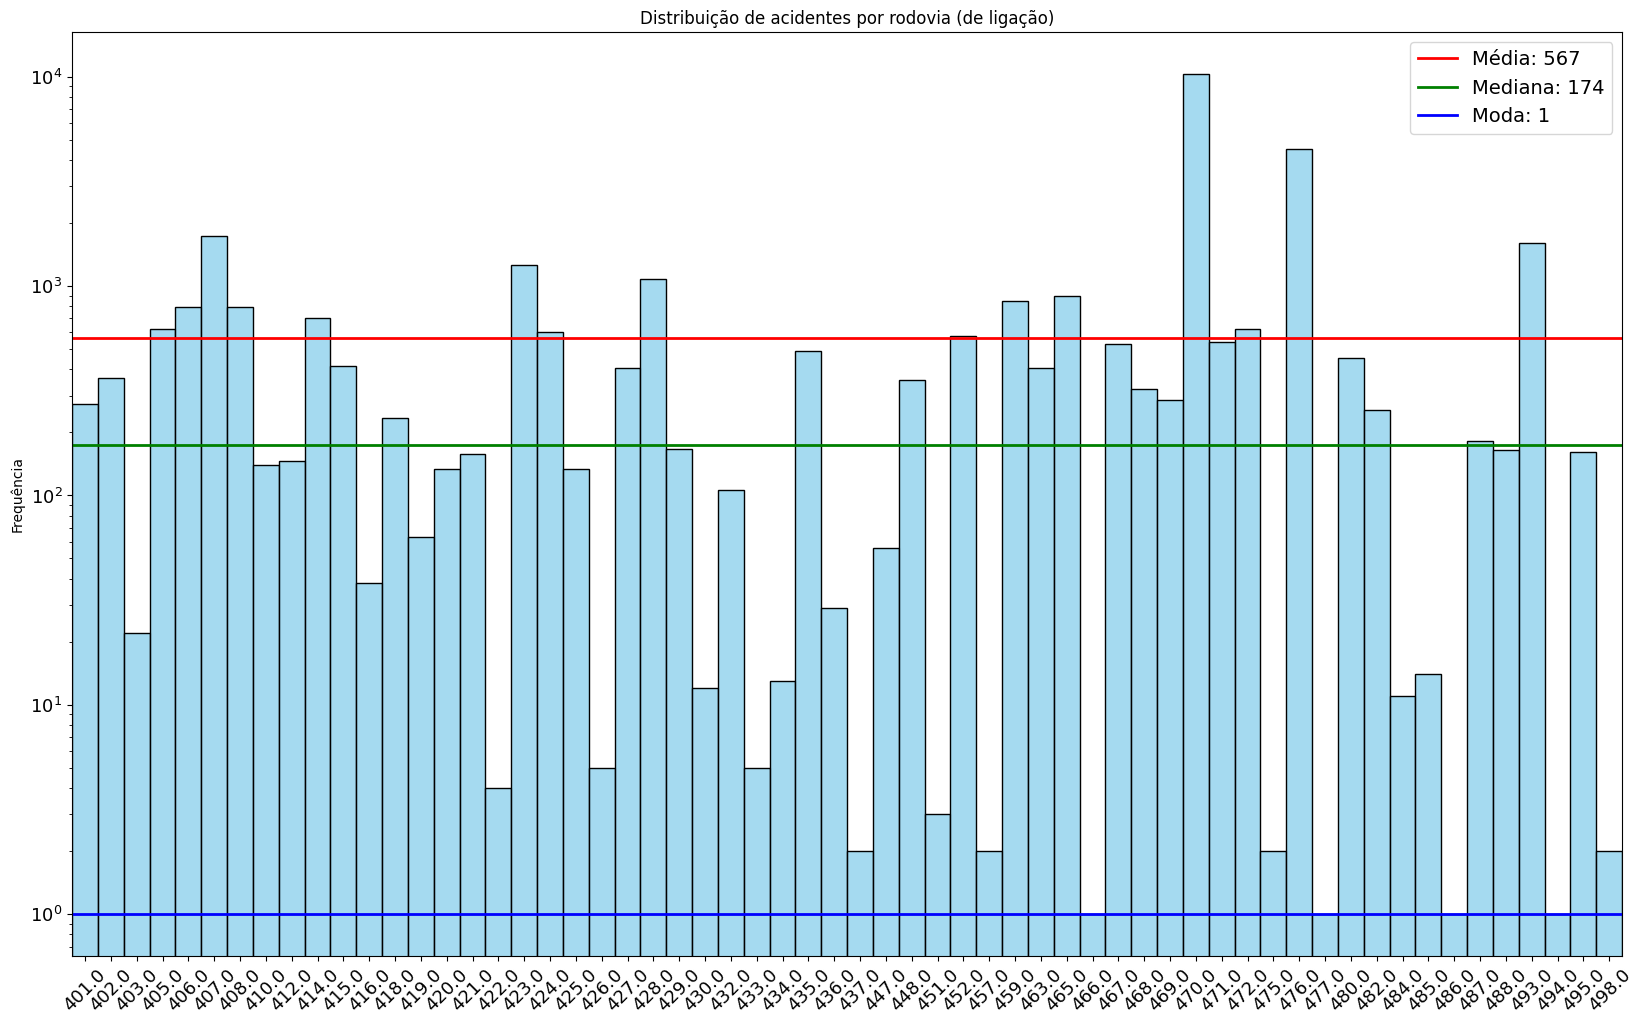

In [30]:
min_value, max_value = 400, 499
df = df_accidents.copy()
df = df.dropna(subset="br")
df = df[(df["br"] >= min_value) & (df["br"] <= max_value)]

draw_histplot(
    df=df["br"].sort_values().astype(str),
    title="Distribuição de acidentes por rodovia (de ligação)",
    orient="h",
    width=20,
    height=12,
    rotation=True,
    set_yscale=True
)

#### Análise da distribuição de maior número de acidentes por uso do solo

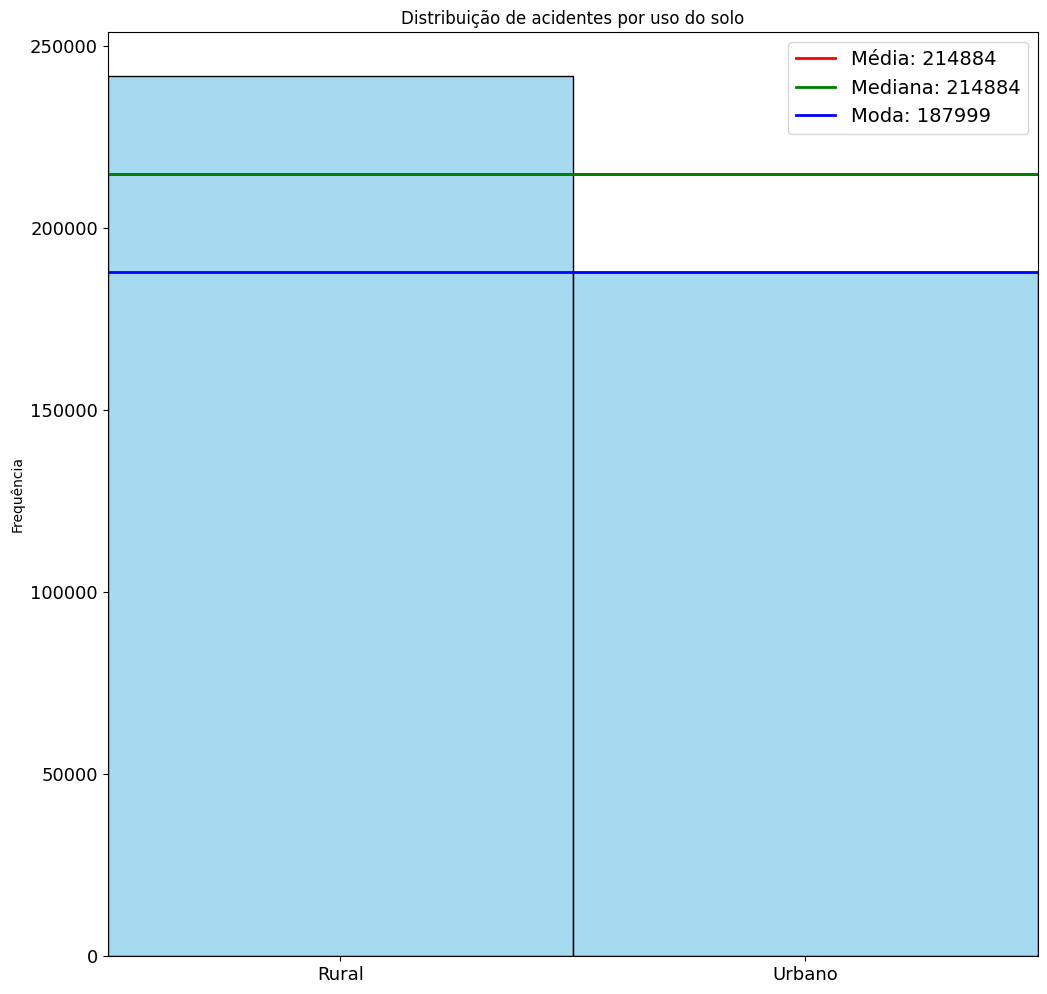

In [31]:
df = df_accidents.copy()
df = df.dropna(subset="uso_solo")
draw_histplot(
    df=df["uso_solo"].sort_values().astype(str),
    title="Distribuição de acidentes por uso do solo",
    orient="h",
    width=12,
    height=12
)

#### Análise da distribuição de maior número de acidentes por tipo de pista

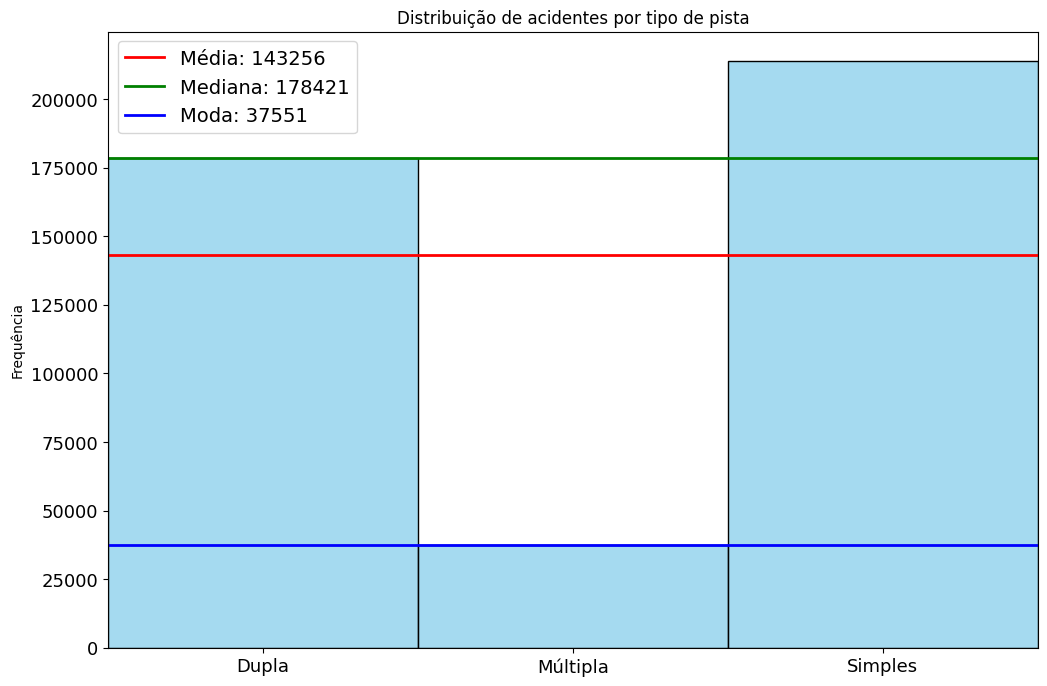

In [32]:
df = df_accidents.copy()
df = df.dropna(subset="tipo_pista")

draw_histplot(
    df=df["tipo_pista"].sort_values().astype(str),
    title="Distribuição de acidentes por tipo de pista",
    orient="h",
    width=12,
    height=8
)

#### Análise da distribuição de maior número de acidentes por sentido da via

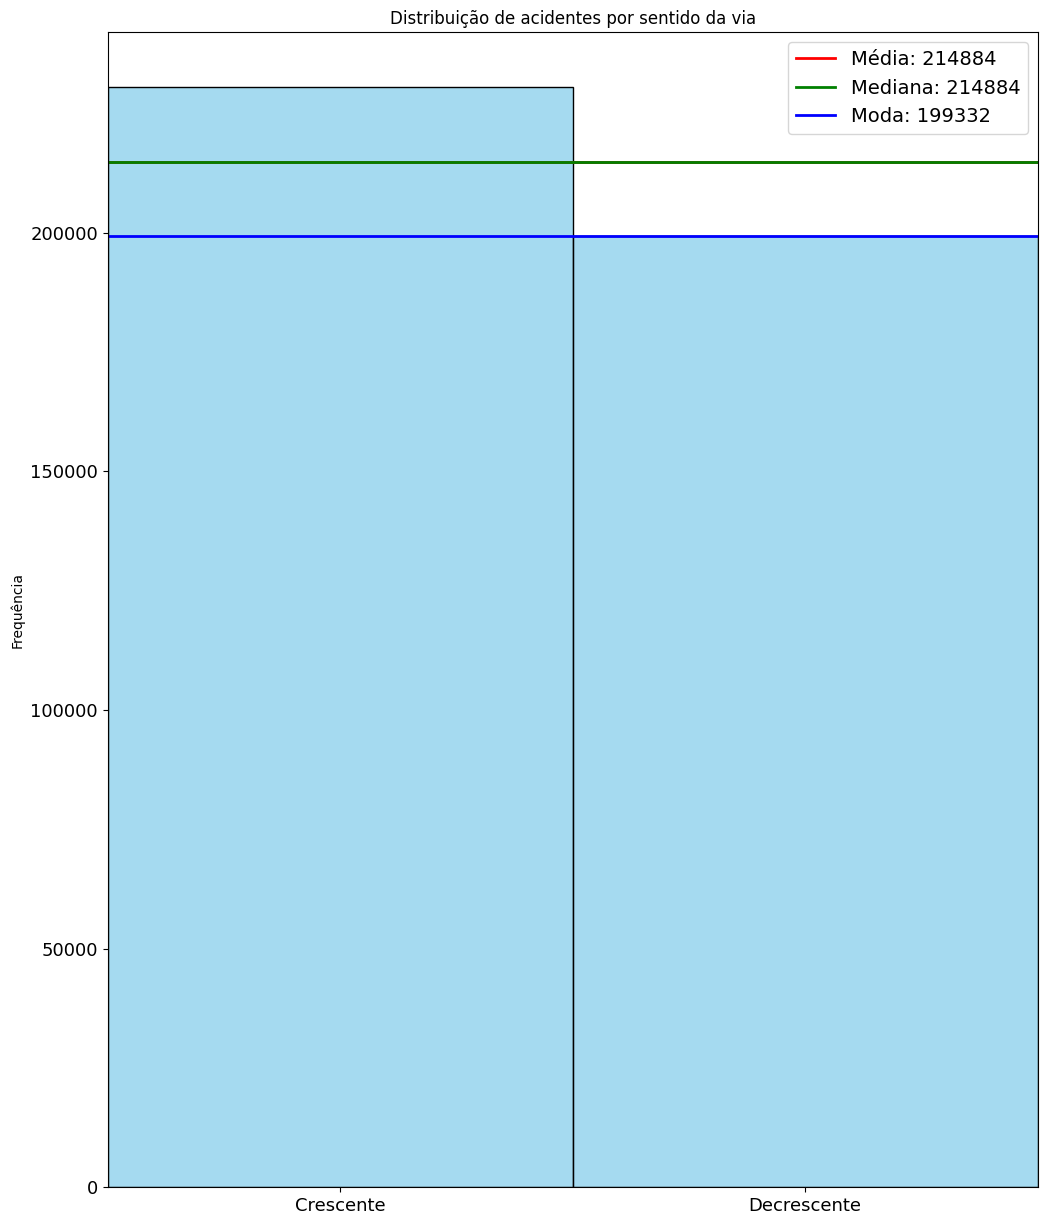

In [33]:
df = df_accidents.copy()
df = df.dropna(subset="sentido_via")
draw_histplot(
    df=df["sentido_via"].sort_values().astype(str),
    title="Distribuição de acidentes por sentido da via",
    orient="h",
    width=12,
    height=15
)

#### Análise da distribuição de maior número de acidentes por tipo de acidente

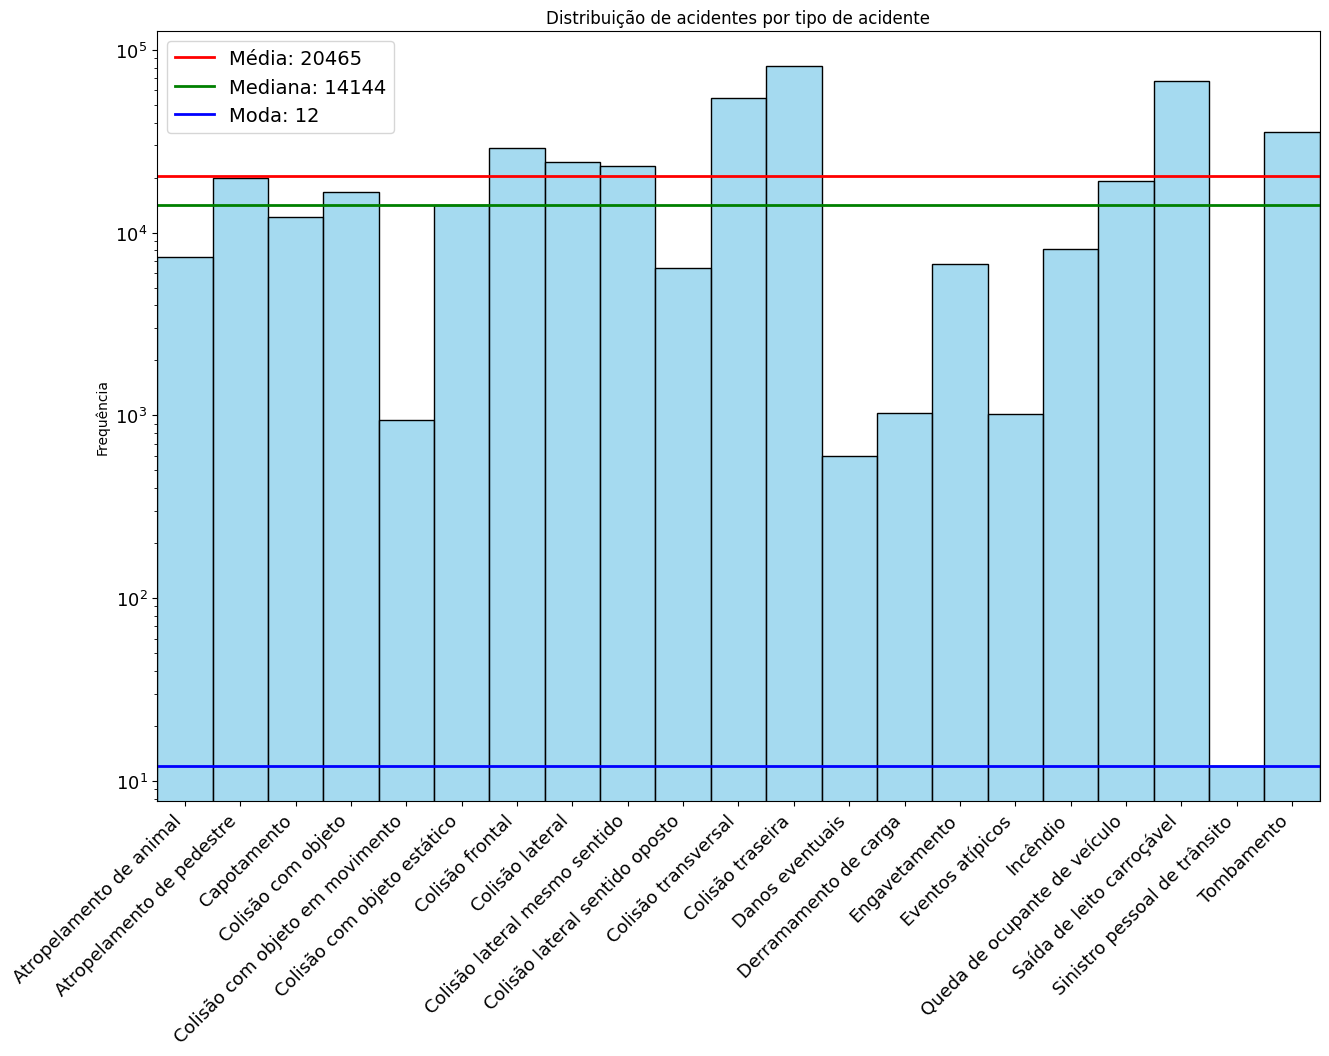

In [34]:
df = df_accidents.copy()
df = df.dropna(subset="tipo_acidente")

draw_histplot(
    df=df["tipo_acidente"].sort_values().astype(str),
    title="Distribuição de acidentes por tipo de acidente",
    orient="h",
    width=15,
    height=10,
    rotation=True,
    set_yscale=True,
    center_x_label=False
)

#### Análise da distribuição de maior número de acidentes por causa de acidente

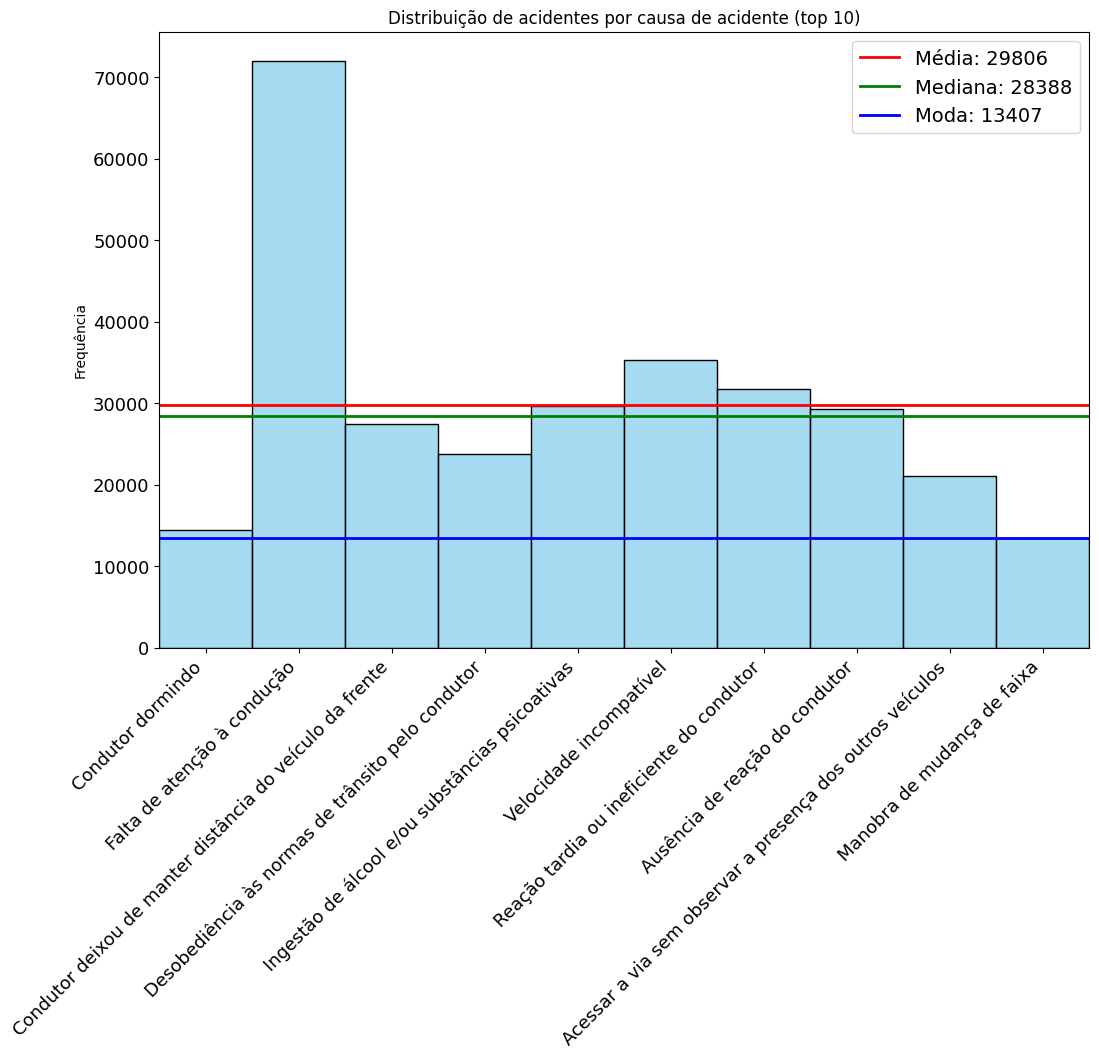

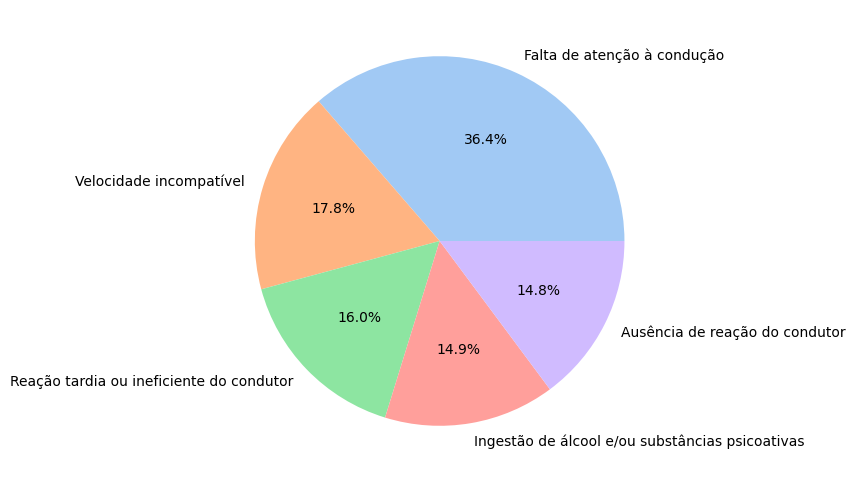

In [35]:
df = df_accidents.copy()
df = df.dropna(subset="causa_acidente")

df_top5 = df[df["causa_acidente"].isin(
    df["causa_acidente"].value_counts().nlargest(10).index)]

draw_histplot(
    df=df_top5["causa_acidente"],
    title="Distribuição de acidentes por causa de acidente (top 10)",
    orient="h",
    width=12,
    height=8,
    rotation=True,
    center_x_label=False
)

df = df_accidents.copy()
df = df.dropna(subset="causa_acidente")
df = df["causa_acidente"].value_counts().reset_index()
df.columns = ["causa_acidente", "frequencia"]
df = df.head(5)


draw_pie(
    df=df["frequencia"],
    labels=df["causa_acidente"],
    figsize=(6, 6)
)

#### Análise da distribuição de maior número de acidentes por classificação de acidente

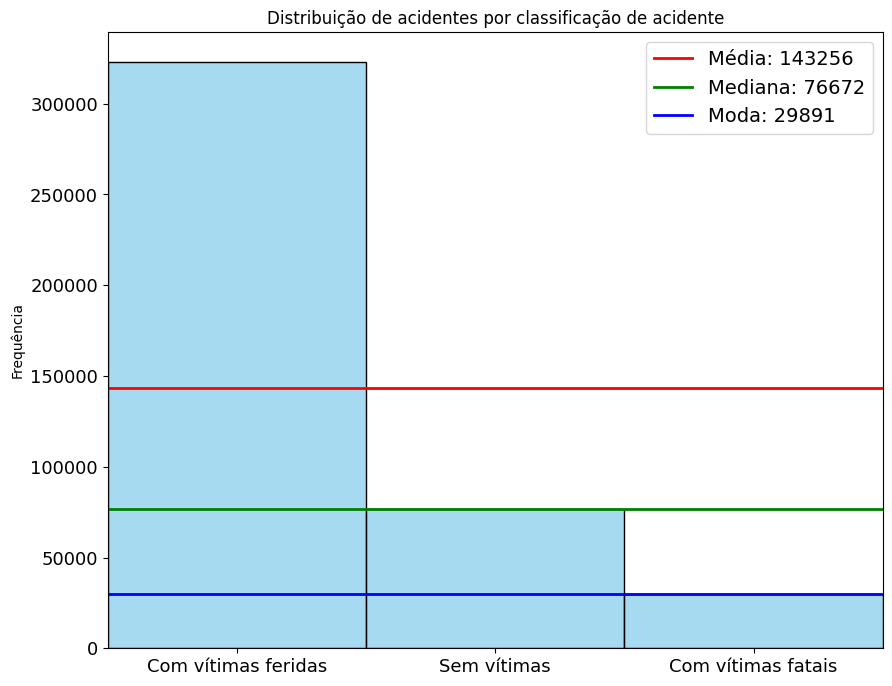

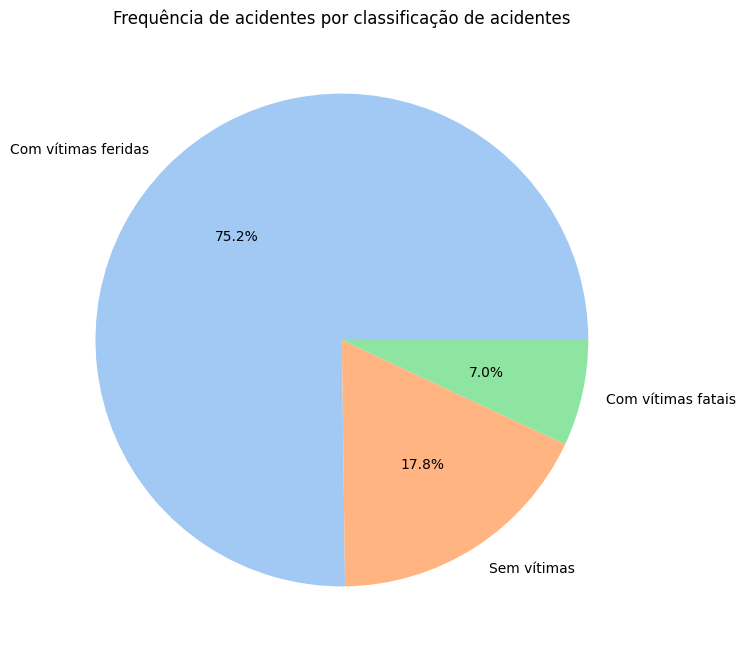

In [36]:
df = df_accidents.copy()
df = df.dropna(subset="classificacao_acidente")

draw_histplot(
    df=df["classificacao_acidente"],
    title="Distribuição de acidentes por classificação de acidente",
    orient="h",
    width=10,
    height=8
)

df = df_accidents.copy()
df = df["classificacao_acidente"].value_counts().reset_index()
df.columns = ["classificacao_acidente", "frequencia"]

draw_pie(
    df=df["frequencia"],
    labels=df["classificacao_acidente"],
    title="Frequência de acidentes por classificação de acidentes"
)

#### Análise da distribuição de acidentes por pessoas

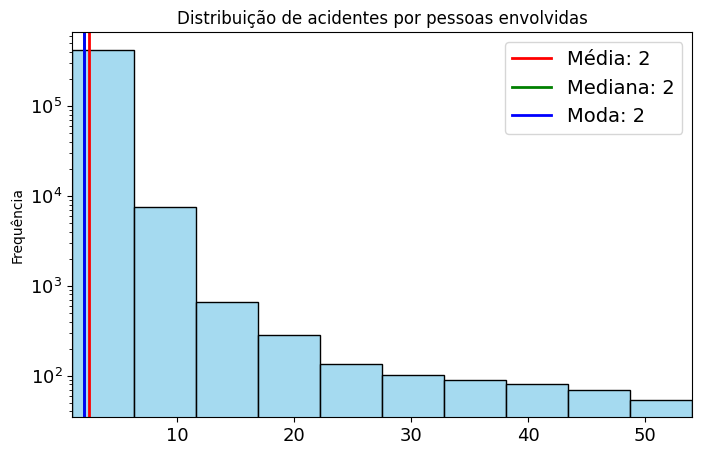

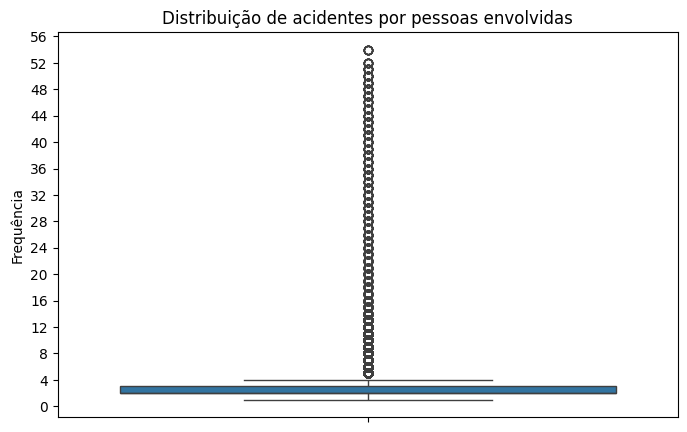

In [37]:
df = df_accidents.copy()
df = df.dropna(subset="pessoas")
draw_histplot(
    df=df["pessoas"],
    bins=10,
    title="Distribuição de acidentes por pessoas envolvidas",
    set_yscale=True
)

draw_boxplot(
    df=df["pessoas"].reset_index(),
    multipleLocator=4,
    title="Distribuição de acidentes por pessoas envolvidas"
)

#### Análise da distribuição de acidentes por veículos

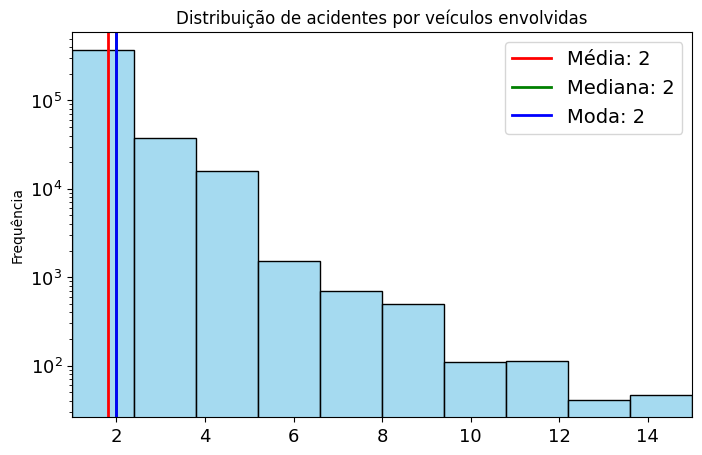

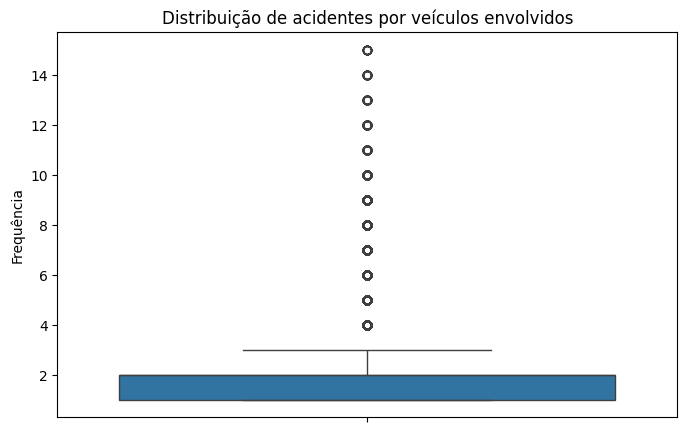

In [38]:
df = df_accidents.copy()
df = df.dropna(subset="veiculos")

draw_histplot(
    df=df["veiculos"],
    bins=10,
    title="Distribuição de acidentes por veículos envolvidas",
    set_yscale=True
)

draw_boxplot(
    df=df["veiculos"].reset_index(),
    multipleLocator=2,
    title="Distribuição de acidentes por veículos envolvidos"
)

## Análise bivariada

### Tipo de acidente

#### tipo_acidente x tipo_data

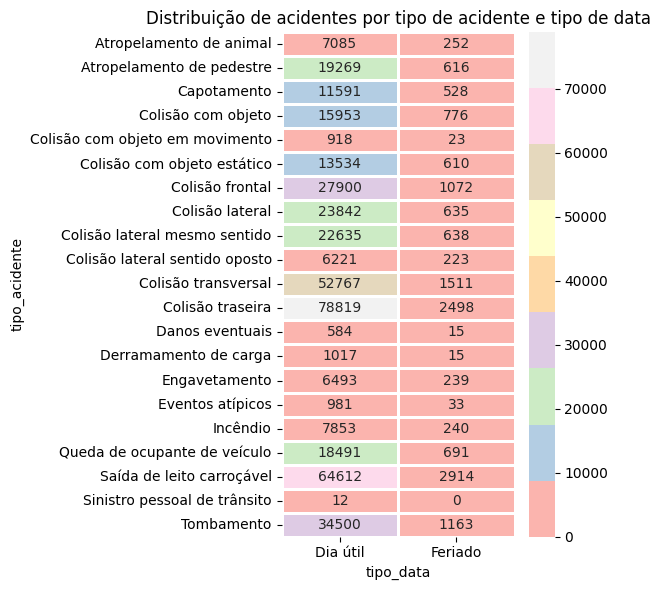

In [39]:
df = df_accidents.copy()
df.dropna(inplace=True)
df["tipo_data"] = np.where(df["tipo_data"] == "Dia útil", "Dia útil", "Feriado")
df = df.groupby(['tipo_acidente', 'tipo_data']).size().unstack().fillna(0)


plt.figure(figsize=(6, 6))
sns.heatmap(df, cmap="Pastel1", annot=True, fmt=".0f", lw=1)
plt.title("Distribuição de acidentes por tipo de acidente e tipo de data")
plt.tight_layout()
plt.show()

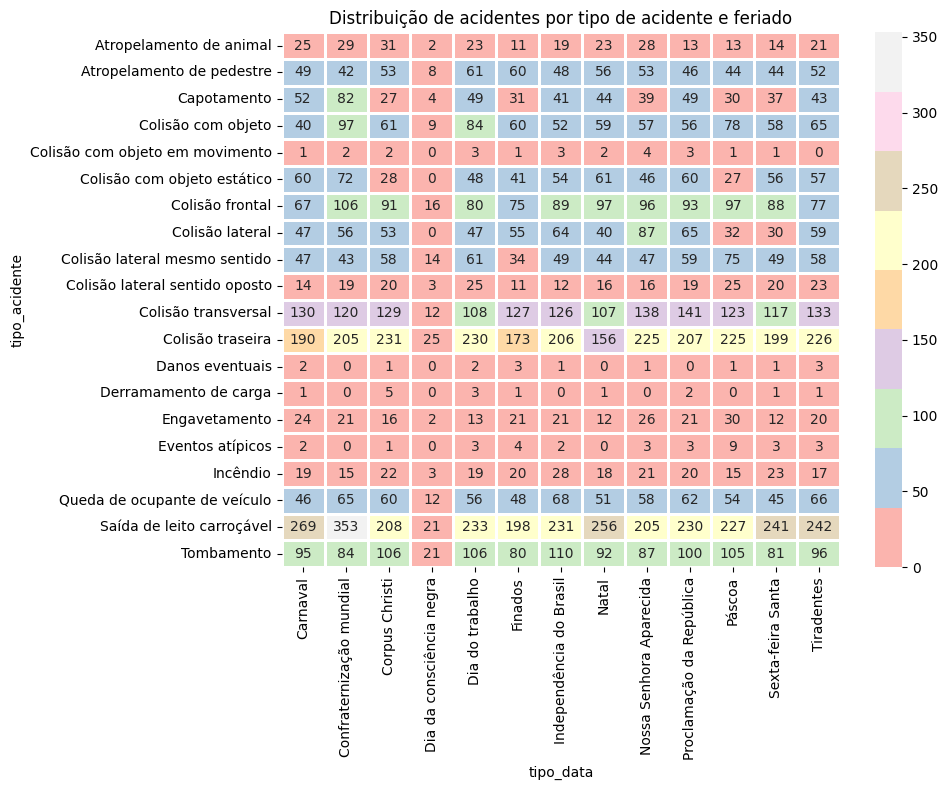

In [40]:
df = df_accidents.copy()
df.dropna(inplace=True)
df = df[df["tipo_data"] != "Dia útil"]
df = df.groupby(['tipo_acidente', 'tipo_data']).size().unstack().fillna(0)


plt.figure(figsize=(10, 8))
sns.heatmap(df, cmap="Pastel1", annot=True, fmt=".0f", lw=1)
plt.title("Distribuição de acidentes por tipo de acidente e feriado")
plt.tight_layout()
plt.show()

#### tipo_acidente x mes_ano (ano)

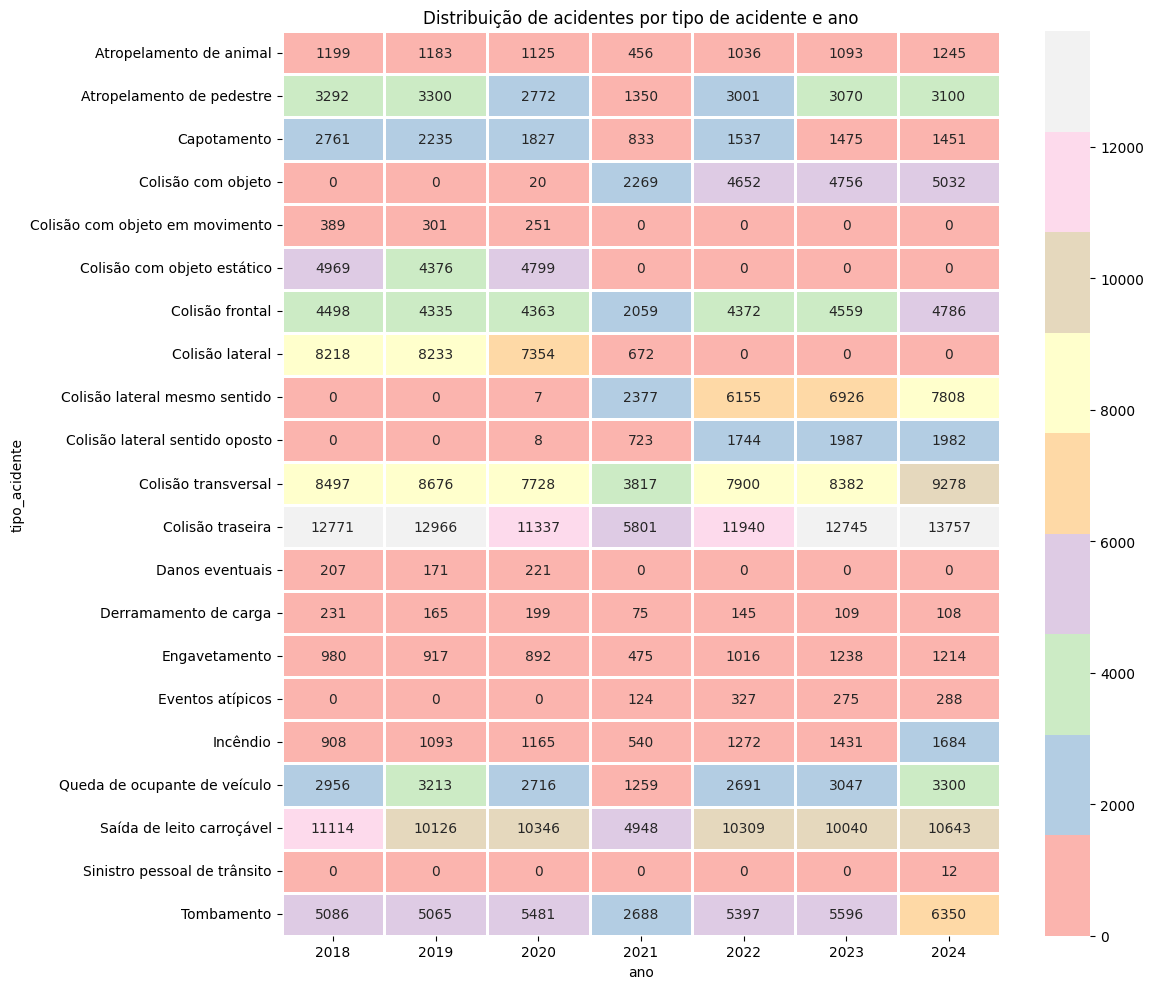

In [41]:
df = df_accidents.copy()
df.dropna(inplace=True)
df["mes_ano"] = df["mes_ano"].dt.year
df = df.groupby(['tipo_acidente', 'mes_ano']).size().unstack().fillna(0)
df.columns.name = "ano"

plt.figure(figsize=(12, 10))
sns.heatmap(df, cmap="Pastel1", annot=True, fmt=".0f", lw=1)
plt.title("Distribuição de acidentes por tipo de acidente e ano")
plt.tight_layout()
plt.show()

#### tipo_acidente x dia_semana

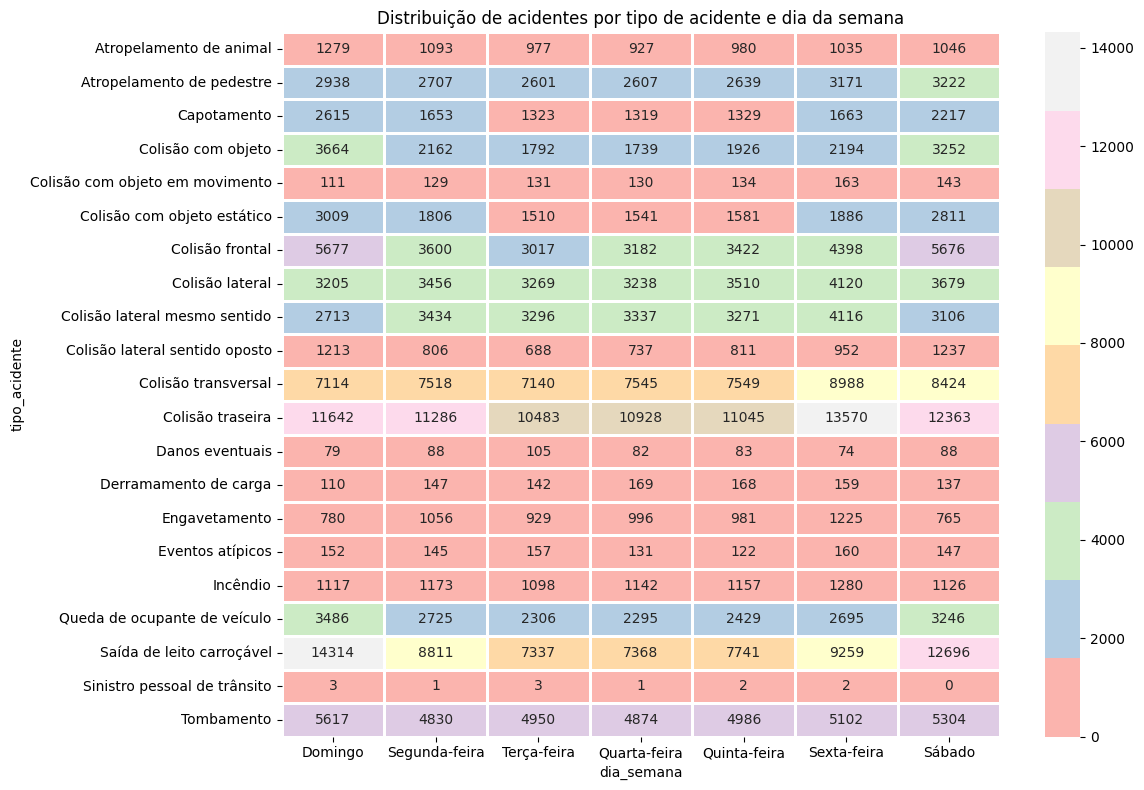

In [42]:
df = df_accidents.copy()
df.dropna(inplace=True)
df = df.groupby(['tipo_acidente', 'dia_semana']).size().unstack().fillna(0)
df = df[get_weekdays()]

plt.figure(figsize=(12, 8))
sns.heatmap(df, cmap="Pastel1", annot=True, fmt=".0f", lw=1)
plt.title("Distribuição de acidentes por tipo de acidente e dia da semana")
plt.tight_layout()
plt.show()

#### tipo_acidente x horario

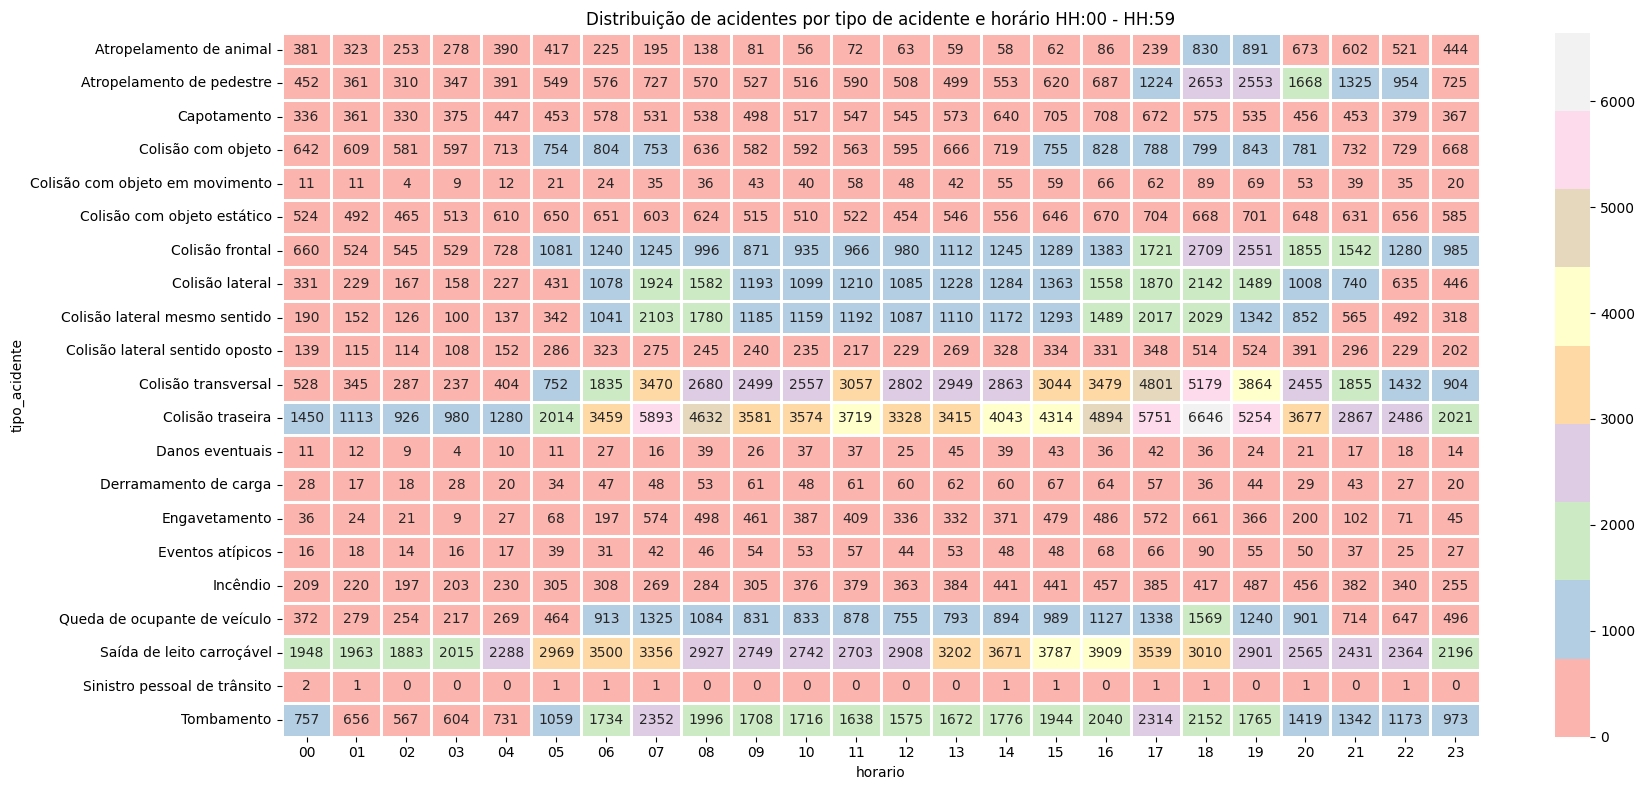

In [43]:
df = df_accidents.copy()
df.dropna(inplace=True)
df.loc[:, "horario"] = to_datetime(df["horario"]).astype(str).str.zfill(2)
df = df.groupby(['tipo_acidente', 'horario']).size().unstack().fillna(0)

plt.figure(figsize=(18, 8))
sns.heatmap(df, cmap="Pastel1", annot=True, fmt=".0f", lw=1)
plt.title("Distribuição de acidentes por tipo de acidente e horário HH:00 - HH:59")
plt.tight_layout()
plt.show()

#### tipo_acidente x fase_dia

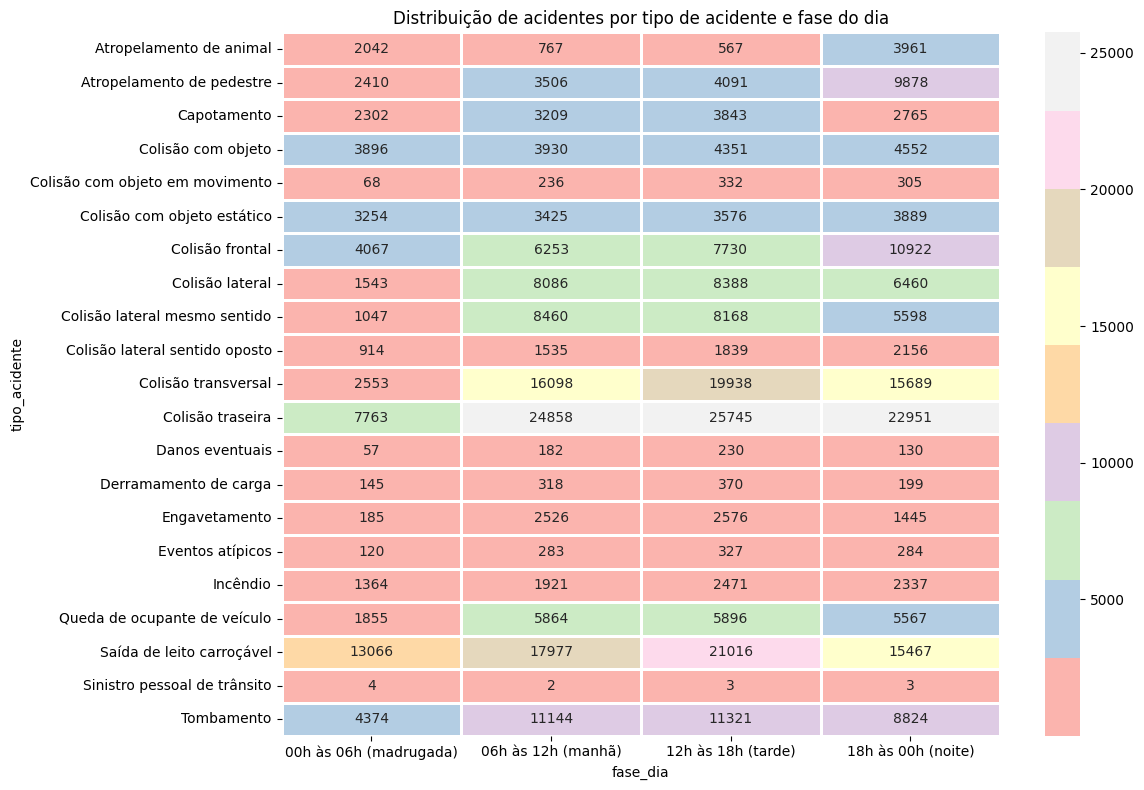

In [44]:
df = df_accidents.copy()
df.dropna(inplace=True)
df = df.groupby(['tipo_acidente', 'fase_dia']).size().unstack().fillna(0)


plt.figure(figsize=(12, 8))
sns.heatmap(df, cmap="Pastel1", annot=True, fmt=".0f", lw=1)
plt.title("Distribuição de acidentes por tipo de acidente e fase do dia")
plt.tight_layout()
plt.show()

#### tipo_acidente x condicao_metereologica

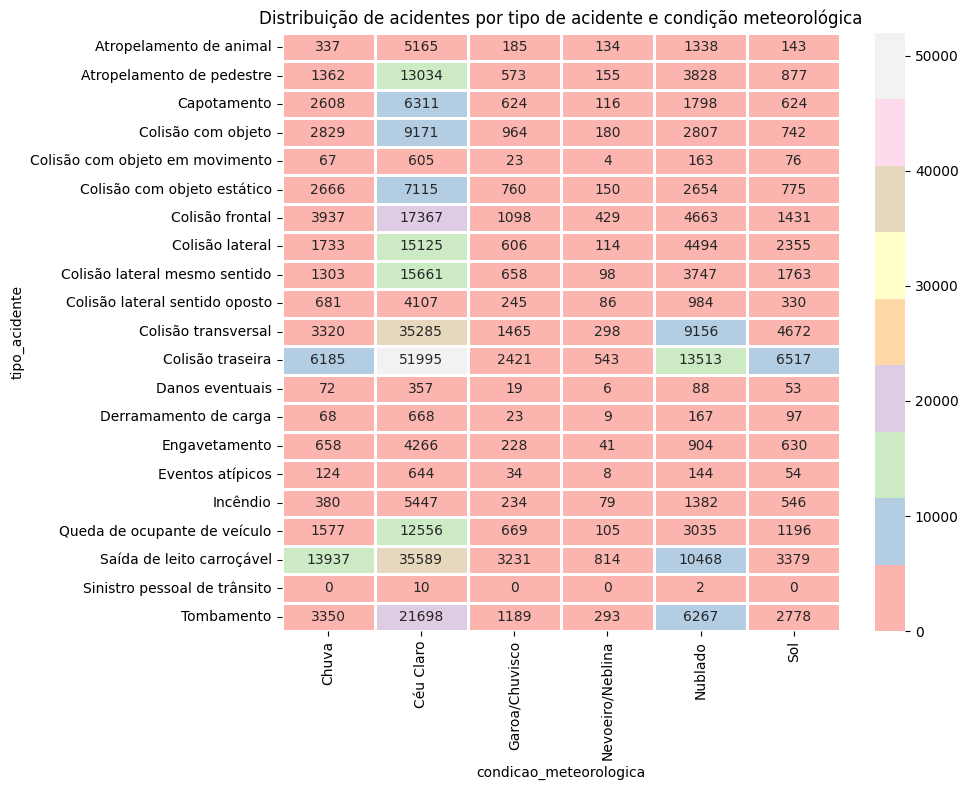

In [45]:
df = df_accidents.copy()
df.dropna(inplace=True)
# Sem dados expressivos para análise
df = df[~df["condicao_metereologica"].isin(["Neve", "Granizo", "Vento"])]
df = df.groupby(
    [
        'tipo_acidente',
        'condicao_metereologica'
    ]
).size().unstack().fillna(0)
df.columns.name = "condicao_meteorologica"

plt.figure(figsize=(10, 8))
sns.heatmap(df, cmap="Pastel1", annot=True, fmt=".0f", lw=1)
plt.title("Distribuição de acidentes por tipo de acidente e condição meteorológica")
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

#### tipo_acidente x uf (com todos o estados)

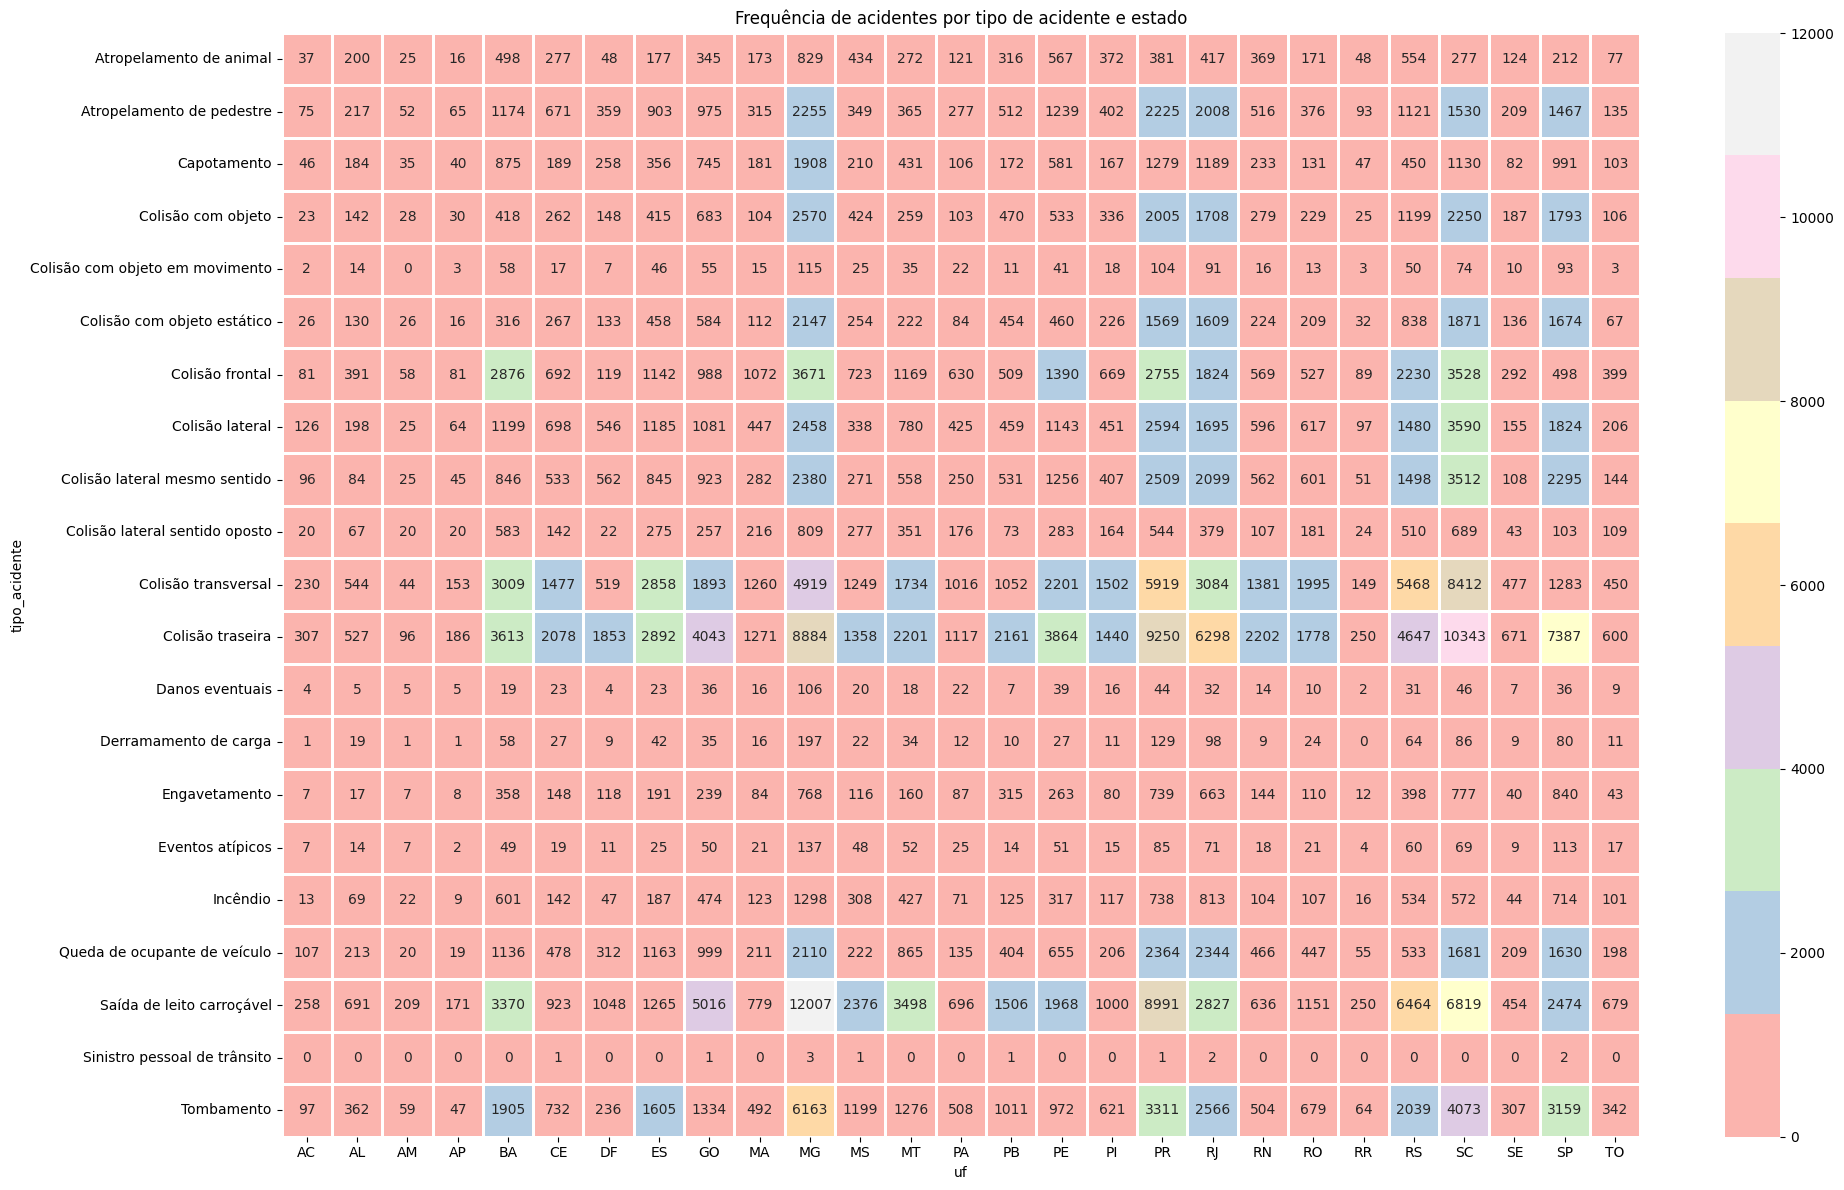

In [46]:
df = df_accidents.copy()
df.dropna(inplace=True)
df = df.groupby(['tipo_acidente', 'uf']).size().unstack().fillna(0)

plt.figure(figsize=(20, 12))
sns.heatmap(df, cmap="Pastel1", annot=True, fmt=".0f", lw=1)
plt.title("Frequência de acidentes por tipo de acidente e estado")
plt.tight_layout()
plt.show()

#### tipo_acidente x uf (com dados expressivos para a análise)

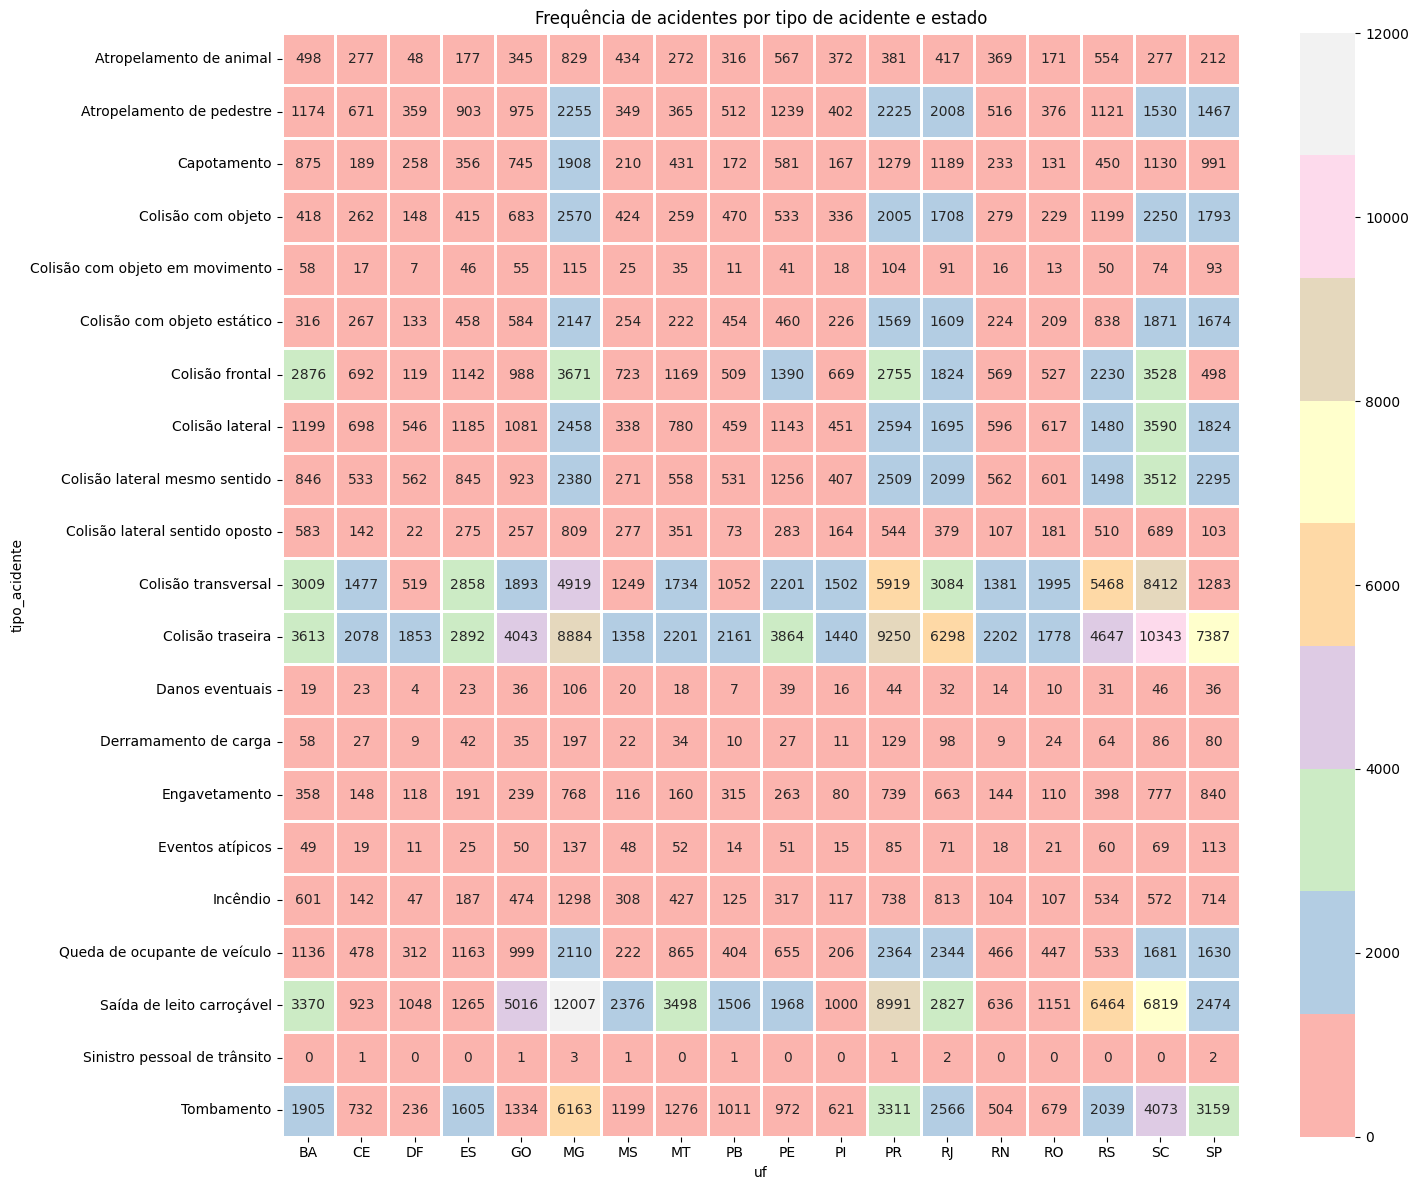

In [47]:
df = df_accidents.copy()
df.dropna(inplace=True)
# Com dados expressivos para análise
df = df[~df["uf"].isin([
    "AC",
    "AL",
    "AM",
    "AP",
    "MA",
    "PA",
    "RR",
    "SE",
    "TO",
])]
df = df.groupby(['tipo_acidente', 'uf']).size().unstack().fillna(0)

plt.figure(figsize=(15, 12))
sns.heatmap(df, cmap="Pastel1", annot=True, fmt=".0f", lw=1)
plt.title("Frequência de acidentes por tipo de acidente e estado")
plt.tight_layout()
plt.show()

#### tipo_acidente x br (com dados expressivos para análise)

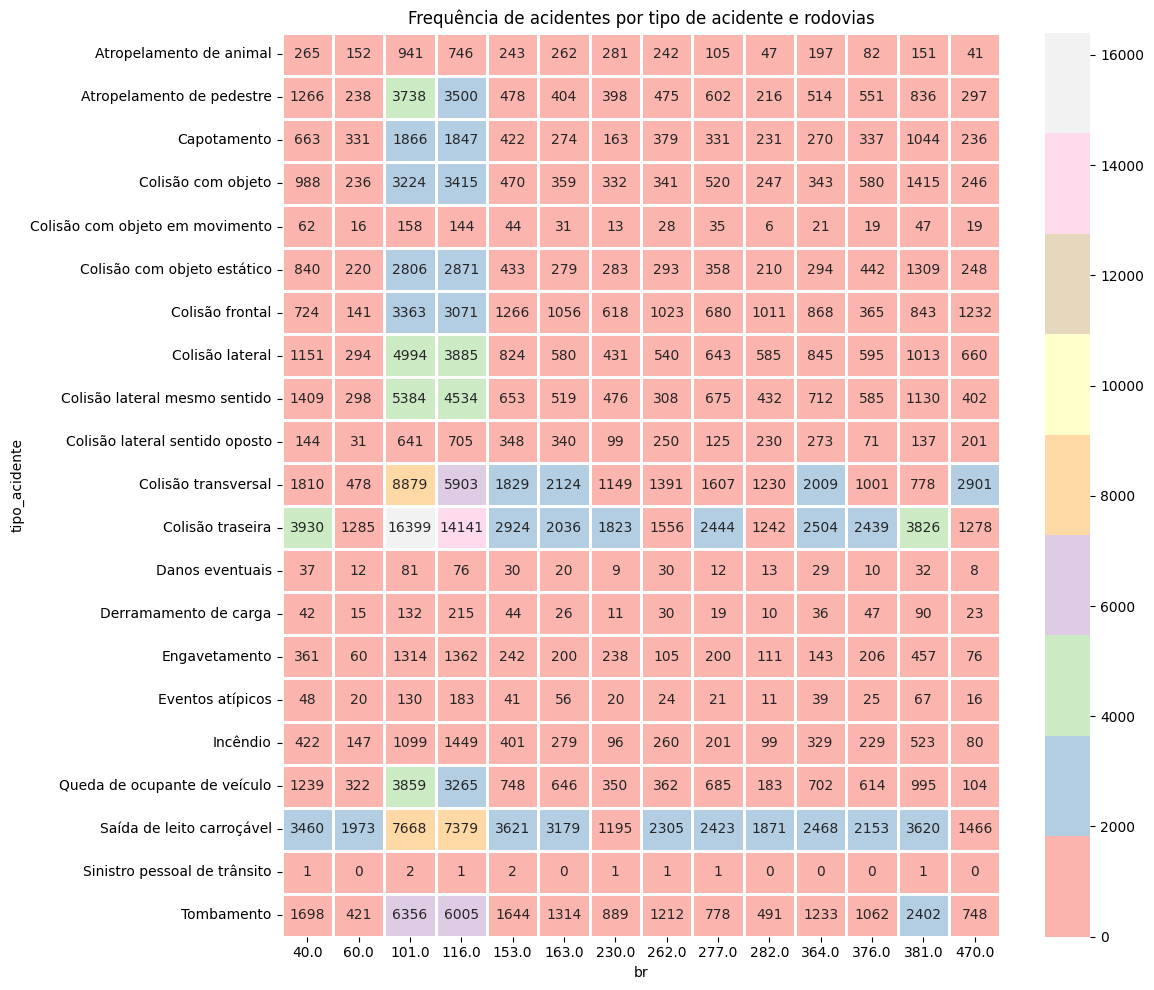

In [48]:
# min_value, max_value = 10, 99

df = df_accidents.copy()
df.dropna(inplace=True)
# Com dados expressivos para análise
df = df[df["br"].isin([
    40, 60,
    101, 116, 153, 163,
    230, 262, 277, 282,
    364, 376, 381, 470
])]
df = df.groupby(['tipo_acidente', 'br']).size().unstack().fillna(0)
# df = df[[value for value in df.columns if isinstance(
#     value, (int, float)) and min_value <= value <= max_value]]

plt.figure(figsize=(12, 10))
sns.heatmap(df, cmap="Pastel1", annot=True, fmt=".0f", lw=1)
plt.title("Frequência de acidentes por tipo de acidente e rodovias")
plt.tight_layout()
plt.show()

#### tipo_acidente x uso_solo

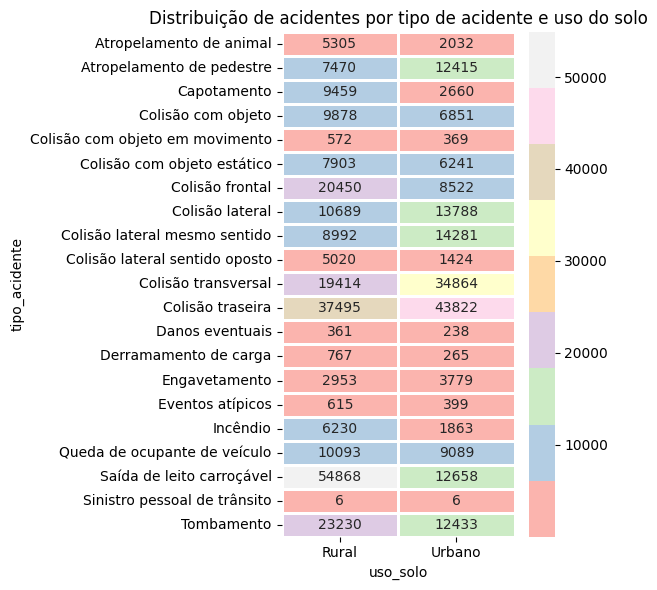

In [49]:
df = df_accidents.copy()
df.dropna(inplace=True)
df = df.groupby(['tipo_acidente', 'uso_solo']).size().unstack().fillna(0)

plt.figure(figsize=(6, 6))
sns.heatmap(df, cmap="Pastel1", annot=True, fmt=".0f", lw=1)
plt.title("Distribuição de acidentes por tipo de acidente e uso do solo")
plt.tight_layout()
plt.show()

#### tipo_acidente x tipo_pista

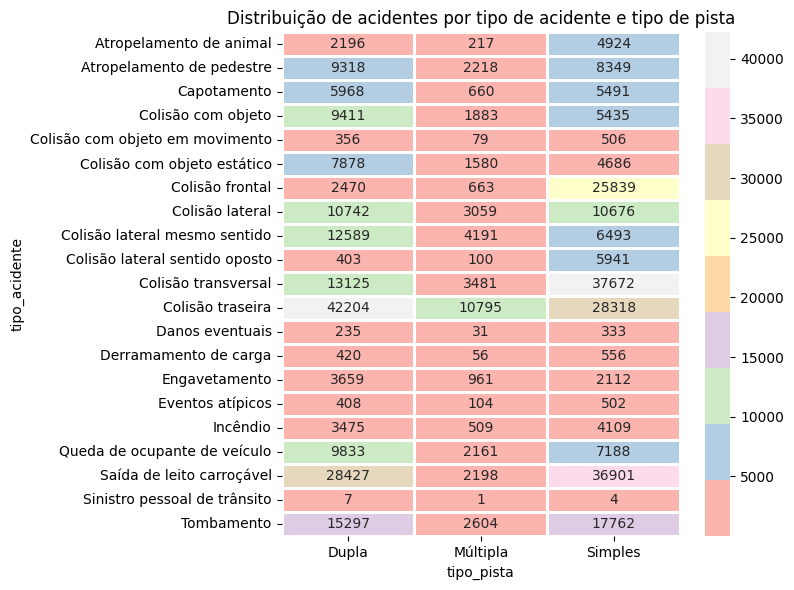

In [50]:
df = df_accidents.copy()
df.dropna(inplace=True)
df = df.groupby(['tipo_acidente', 'tipo_pista']).size().unstack().fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(df, cmap="Pastel1", annot=True, fmt=".0f", lw=1)
plt.title("Distribuição de acidentes por tipo de acidente e tipo de pista")
plt.tight_layout()
plt.show()

#### tipo_acidente x sentido_via

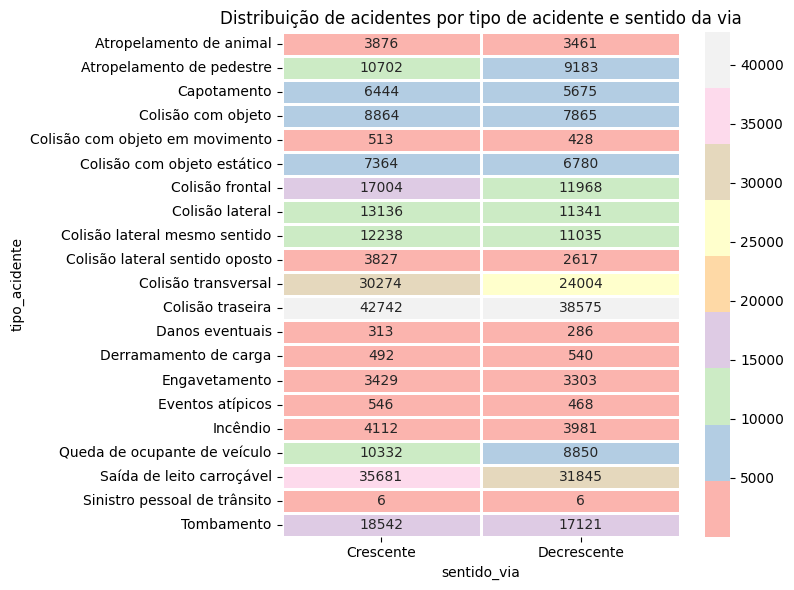

In [51]:
df = df_accidents.copy()
df.dropna(inplace=True)
df = df.groupby(['tipo_acidente', 'sentido_via']).size().unstack().fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(df, cmap="Pastel1", annot=True, fmt=".0f", lw=1)
plt.title("Distribuição de acidentes por tipo de acidente e sentido da via")
plt.tight_layout()
plt.show()

#### tipo_acidente x causa_acidente (10 principais)

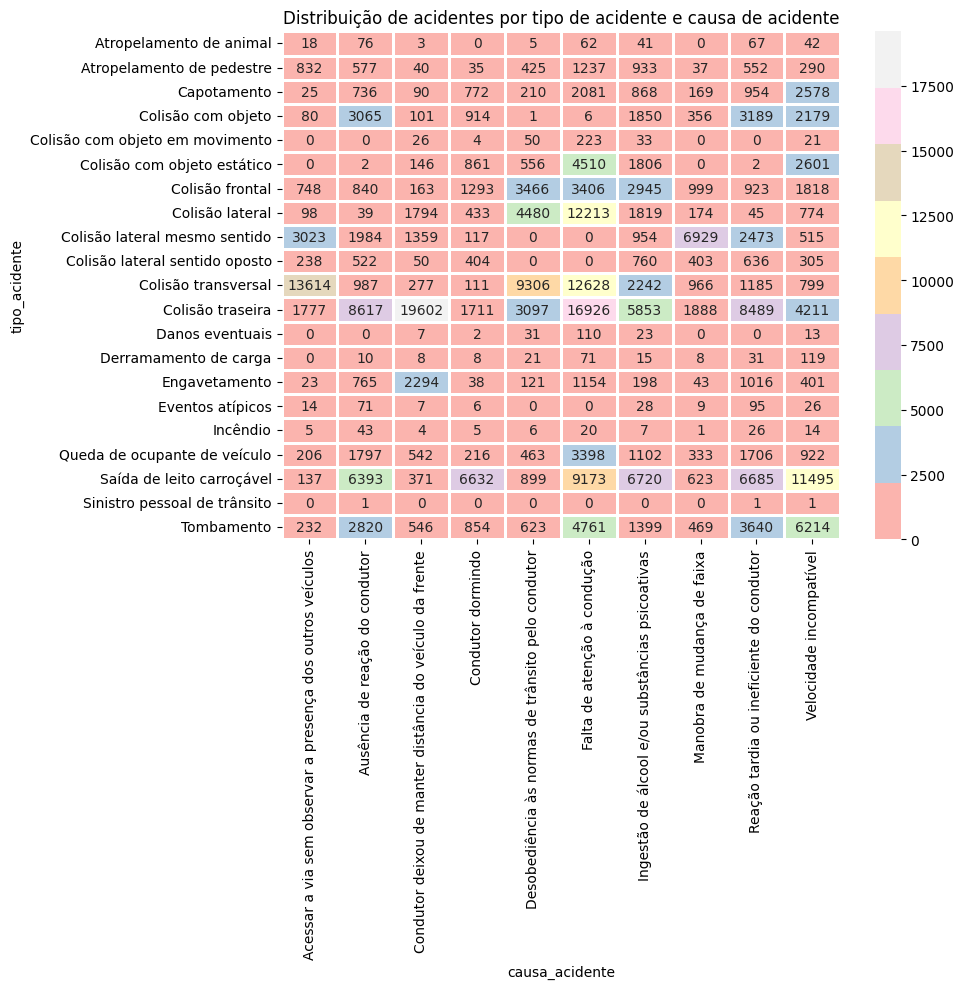

In [52]:
df = df_accidents.copy()
df.dropna(inplace=True)
df = df[df["causa_acidente"].isin(
    df["causa_acidente"].value_counts().nlargest(10).index)]
df = df.groupby(['tipo_acidente', 'causa_acidente']).size().unstack().fillna(0)

plt.figure(figsize=(10, 10))
sns.heatmap(df, cmap="Pastel1", annot=True, fmt=".0f", lw=1)
plt.title(
    "Distribuição de acidentes por tipo de acidente e causa de acidente")
plt.tight_layout()
plt.show()

#### tipo_acidente x classificacao_acidente

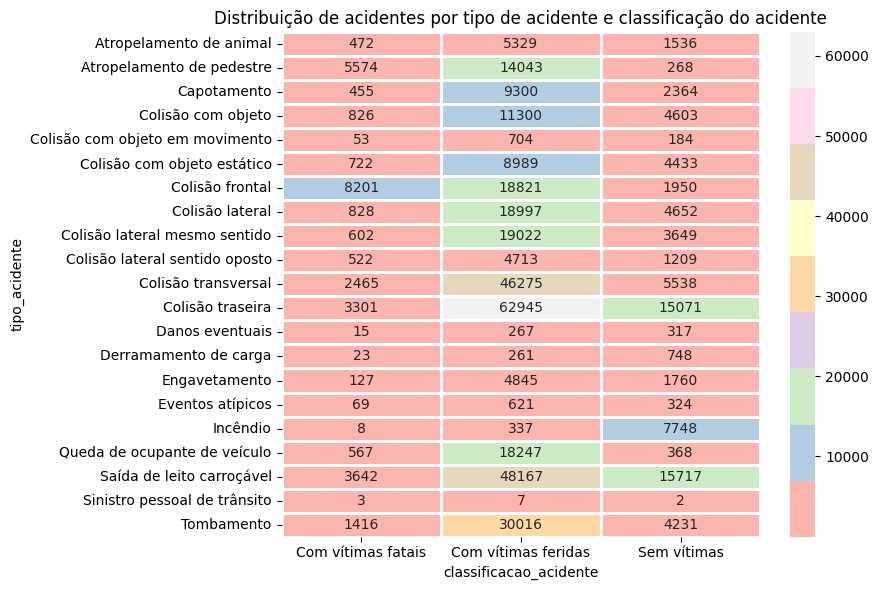

In [53]:
df = df_accidents.copy()
df.dropna(inplace=True)
df = df.groupby(
    [
        'tipo_acidente',
        'classificacao_acidente'
    ]
).size().unstack().fillna(0)

plt.figure(figsize=(9, 6))
sns.heatmap(df, cmap="Pastel1", annot=True, fmt=".0f", lw=1)
plt.title(
    "Distribuição de acidentes por tipo de acidente e classificação do acidente")
plt.tight_layout()
plt.show()

#### tipo_acidente x pessoas (top 4)

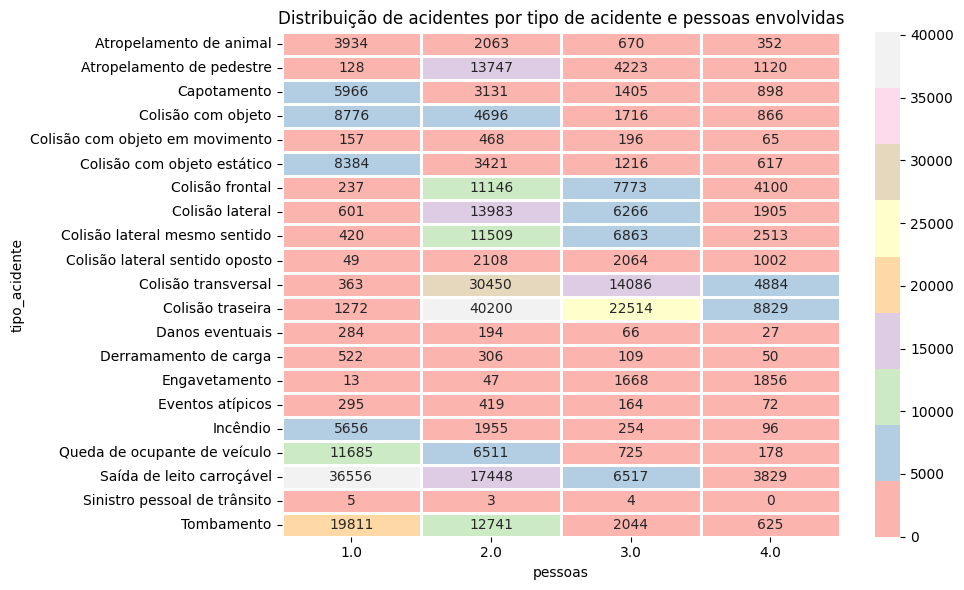

In [54]:
df = df_accidents.copy()
df.dropna(inplace=True)
df = df[df["pessoas"].isin(
    df["pessoas"].value_counts().nlargest(4).index)]
df = df.groupby(['tipo_acidente', 'pessoas']).size().unstack().fillna(0)

plt.figure(figsize=(10, 6))
sns.heatmap(df, cmap="Pastel1", annot=True, fmt=".0f", lw=1)
plt.title(
    "Distribuição de acidentes por tipo de acidente e pessoas envolvidas")
plt.tight_layout()
plt.show()

#### tipo_acidente x veiculos (top 3)

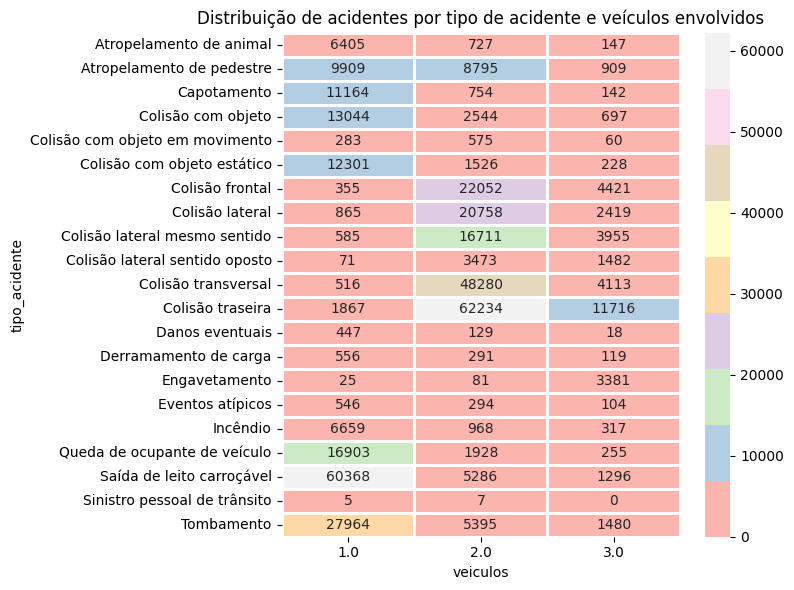

In [55]:
df = df_accidents.copy()
df.dropna(inplace=True)
df = df[df["veiculos"].isin(
    df["veiculos"].value_counts().nlargest(3).index)]
df = df.groupby(['tipo_acidente', 'veiculos']).size().unstack().fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(df, cmap="Pastel1", annot=True, fmt=".0f", lw=1)
plt.title("Distribuição de acidentes por tipo de acidente e veículos envolvidos")
plt.tight_layout()
plt.show()

## Análise multivariada

### Cramers V para identificar a correlação entre as categorias

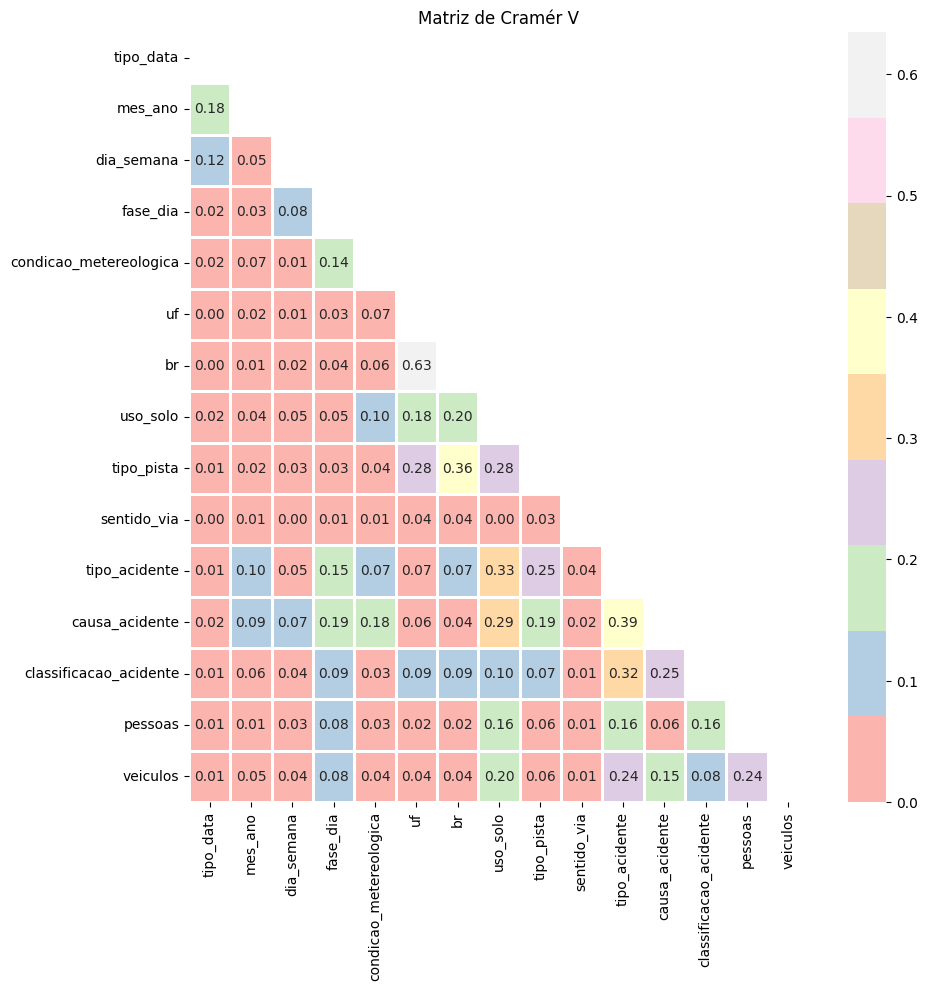

In [67]:
df_correlation = df_accidents.copy()
df_correlation.dropna(inplace=True)
df_correlation.drop(columns=["horario", "km"], inplace=True)
df_correlation.set_index("id", inplace=True)


def apply_cramers_v(crosstab):
    chi2, _, _, _ = chi2_contingency(crosstab)
    n = crosstab.sum().sum()
    r, k = crosstab.shape
    phi2 = chi2 / n
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))


cols = df_correlation.columns
n = len(cols)

df_results = pd.DataFrame(index=cols, columns=cols, dtype=float)

for i in range(n):
    for j in range(i, n):
        col_x = cols[i]
        col_y = cols[j]
        result = apply_cramers_v(pd.crosstab(
            df_correlation[col_x], df_correlation[col_y]))
        df_results.loc[col_x, col_y] = result
        df_results.loc[col_y, col_x] = result

plt.figure(figsize=(10, 10))
sns.heatmap(
    df_results,
    mask=np.triu(np.ones_like(df_results, dtype=bool)),
    fmt=".2f",
    annot=True,
    cmap="Pastel1",
    lw=1
)
plt.title("Matriz de Cramér V")
plt.show()

### Análise dos componentes principais utilizando OneHotEncoding, pois o PCA não explicou nem 30% da base quando utilizei

#### Transformando cada categoria em uma coluna binária

In [57]:
df_pca = df_accidents.copy()
df_pca.set_index("id", inplace=True)
columns_to_remove = [
    "mes_ano",
    "horario",
    "km",
    "br",
    "pessoas",
    "veiculos"
]
df_pca.drop(columns=columns_to_remove, inplace=True)
df_pca = df_pca.reset_index()


encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
X_sparse = encoder.fit_transform(df_pca.select_dtypes(include='object'))
X_sparse

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 5138254 stored elements and shape (467114, 187)>

#### Padronizando as features

In [ ]:
svd = TruncatedSVD(n_components=35)
X_reduzido = svd.fit_transform(X_sparse)
X_reduzido

array([[ 1.19087830e+00, -5.04528897e-10,  6.75380289e-01, ...,
        -3.52734728e-01, -2.02184222e-02,  2.66548714e-02],
       [ 1.36082567e+00,  1.76109250e-10, -9.09001329e-01, ...,
         9.51479154e-02, -6.71886057e-02,  1.63066527e-01],
       [ 1.42828606e+00, -1.63900082e-09, -8.50235417e-01, ...,
         1.00021336e-01, -2.40491271e-02, -5.46471448e-01],
       ...,
       [ 1.38022956e-14,  3.31662479e+00, -1.85732259e-12, ...,
        -1.04364895e-09,  3.05235273e-10, -1.14304816e-09],
       [ 1.38022956e-14,  3.31662479e+00, -1.85732259e-12, ...,
        -1.04364895e-09,  3.05235273e-10, -1.14304816e-09],
       [ 1.38022956e-14,  3.31662479e+00, -1.85732259e-12, ...,
        -1.04364895e-09,  3.05235273e-10, -1.14304816e-09]],
      shape=(467114, 35))

In [68]:
principalDf = pd.DataFrame(
    data=X_reduzido,
    columns=[f'PC{n}' for n in range(1, 36)]
)
principalDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467114 entries, 0 to 467113
Data columns (total 35 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   PC1     467114 non-null  float64
 1   PC2     467114 non-null  float64
 2   PC3     467114 non-null  float64
 3   PC4     467114 non-null  float64
 4   PC5     467114 non-null  float64
 5   PC6     467114 non-null  float64
 6   PC7     467114 non-null  float64
 7   PC8     467114 non-null  float64
 8   PC9     467114 non-null  float64
 9   PC10    467114 non-null  float64
 10  PC11    467114 non-null  float64
 11  PC12    467114 non-null  float64
 12  PC13    467114 non-null  float64
 13  PC14    467114 non-null  float64
 14  PC15    467114 non-null  float64
 15  PC16    467114 non-null  float64
 16  PC17    467114 non-null  float64
 17  PC18    467114 non-null  float64
 18  PC19    467114 non-null  float64
 19  PC20    467114 non-null  float64
 20  PC21    467114 non-null  float64
 21  PC22    46

In [60]:
svd.explained_variance_ratio_

array([0.04604277, 0.10782807, 0.07320968, 0.06103843, 0.05076607,
       0.04031971, 0.03629924, 0.03616434, 0.0332128 , 0.02303396,
       0.02064351, 0.02010374, 0.01885814, 0.01813109, 0.01729077,
       0.01704211, 0.01618433, 0.01570292, 0.01560753, 0.01531575,
       0.01481652, 0.01437721, 0.01370101, 0.01253651, 0.01171354,
       0.01165471, 0.00976464, 0.00942542, 0.00913618, 0.00871442,
       0.00852129, 0.0080509 , 0.00784795, 0.00761334, 0.0073382 ])

In [61]:
sum(svd.explained_variance_ratio_[0:36])*100

np.float64(83.80068221405374)

In [71]:
# plt.figure(figsize=(20, 25))
# sns.heatmap(
#     principalDf.corr(),
#     cmap="Pastel1",
#     mask=np.triu(np.ones_like(principalDf.corr(), dtype=bool)),
#     lw=1
# )
# plt.title("Correlação dos componentes principais", fontsize=20)
# plt.tick_params(axis='x', labelsize=13)
# plt.tick_params(axis='y', labelsize=13)

#### Removendo colunas que não se fazem necessárias após análise

In [ ]:
df = df_accidents.copy()
df.set_index("id", inplace=True)
df.drop(columns=["horario","km"], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467114 entries, 0 to 467113
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      429769 non-null  float64       
 1   tipo_data               429769 non-null  object        
 2   mes_ano                 467114 non-null  datetime64[ns]
 3   dia_semana              429769 non-null  object        
 4   fase_dia                429769 non-null  object        
 5   condicao_metereologica  429769 non-null  object        
 6   uf                      429769 non-null  object        
 7   br                      429769 non-null  float64       
 8   uso_solo                429769 non-null  object        
 9   tipo_pista              429769 non-null  object        
 10  sentido_via             429769 non-null  object        
 11  tipo_acidente           429769 non-null  object        
 12  causa_acidente          429769

#### Salvando os dados em um novo CSV após análise dados

In [ ]:
df_accidents.to_csv(
    path_or_buf="analysis/datatran2018_2024_v3.csv",
    index=False
)